# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Find epoch of minimum validation loss and corresponding metrics
    val_losses = history.history['val_loss']
    min_val_epoch = int(np.argmin(val_losses))            # 0-based
    min_val_loss = float(val_losses[min_val_epoch])
    val_acc_at_min_loss = float(history.history['val_accuracy'][min_val_epoch])

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    metrics = {
        "min_val_epoch": min_val_epoch + 1,   # 1-based for readability
        "min_val_loss": min_val_loss,
        "val_acc_at_min_loss": val_acc_at_min_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

    if return_history:
        return history, metrics
    return metrics

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Activation Function: relu



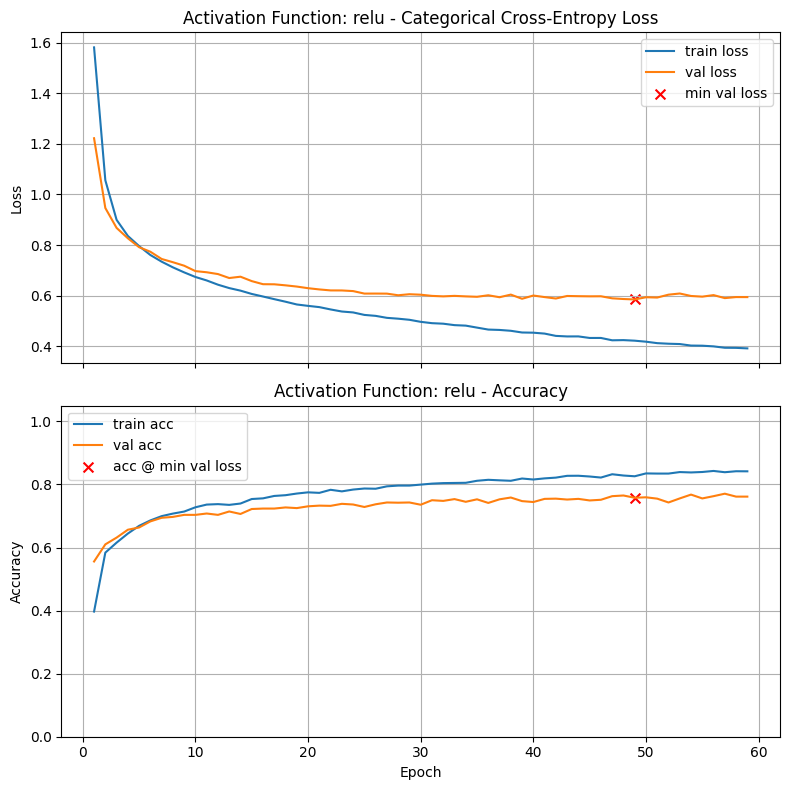

Final Training Loss:            0.3921
Final Training Accuracy:        0.8417
Final Validation Loss:          0.5946
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5853 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.5797
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:09

Activation Function: tanh



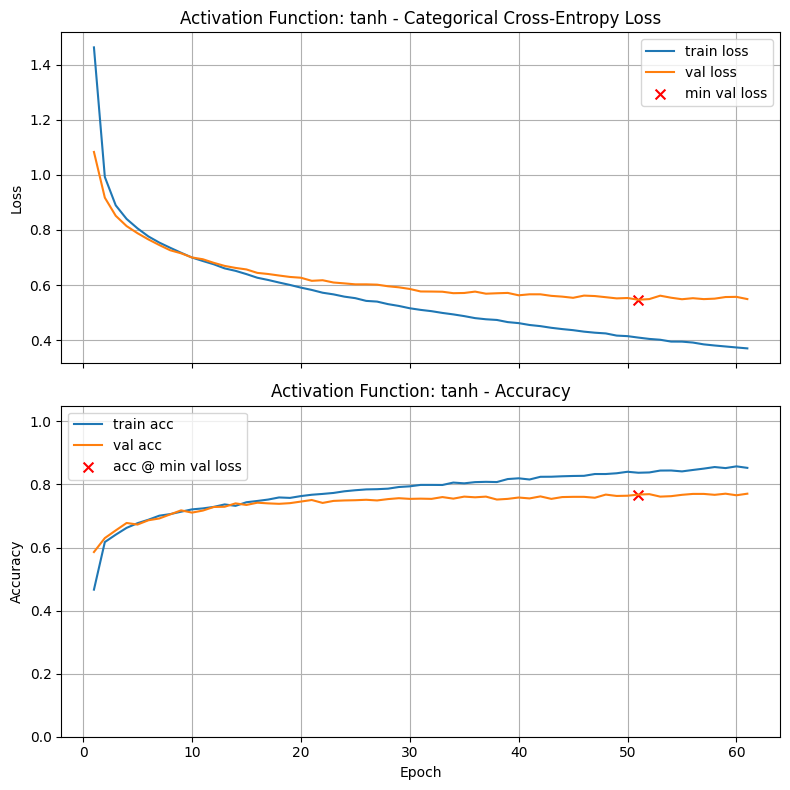

Final Training Loss:            0.3698
Final Training Accuracy:        0.8526
Final Validation Loss:          0.5490
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5466 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.5773
Test Accuracy: 0.7500

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:09

Activation Function: sigmoid



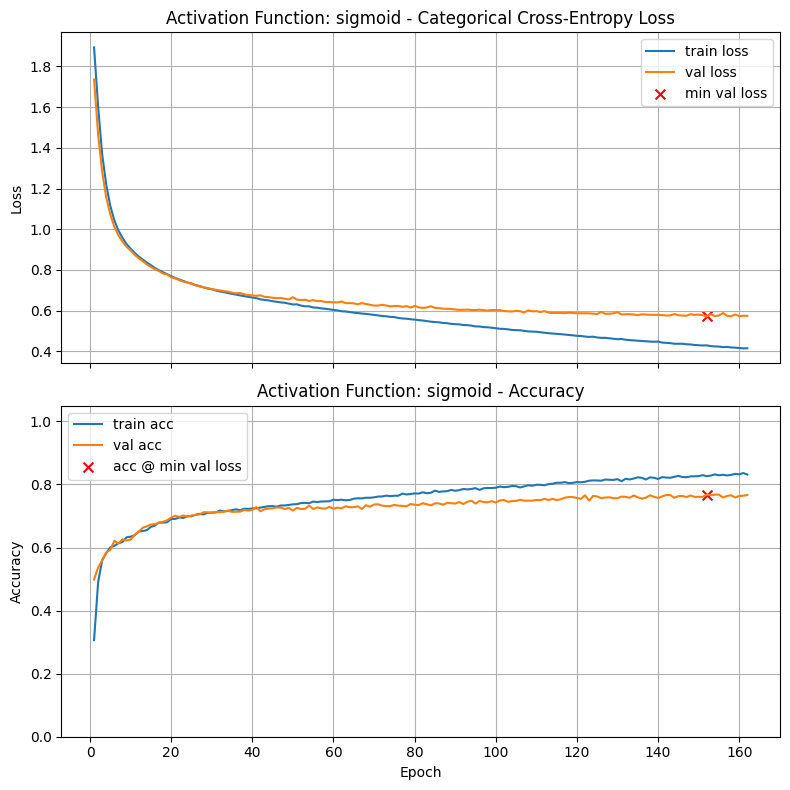

Final Training Loss:            0.4157
Final Training Accuracy:        0.8314
Final Validation Loss:          0.5748
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5717 (Epoch 152)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.5789
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:22


In [9]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

results_1 = pd.DataFrame(columns=['Activation Function', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2])

for i, func in enumerate(activation):
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Activation Function: {func}", verbose=0, return_history = True)
    results_1.loc[i] = [func, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [10]:
results_1

,Activation Function,Best Val Accuracy,Min Val Loss
0,relu,0.757857,0.585329
1,tanh,0.767857,0.546556
2,sigmoid,0.767857,0.571696


### Graded Questions

In [11]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = results_1['Best Val Accuracy'].idxmax()            # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [13]:
# Set a1b to the validation accuracy found by this best activation function

a1b = results_1['Best Val Accuracy'].max()            # Replace 0.0 with your answer

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7679


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Learning Rate: 0.001



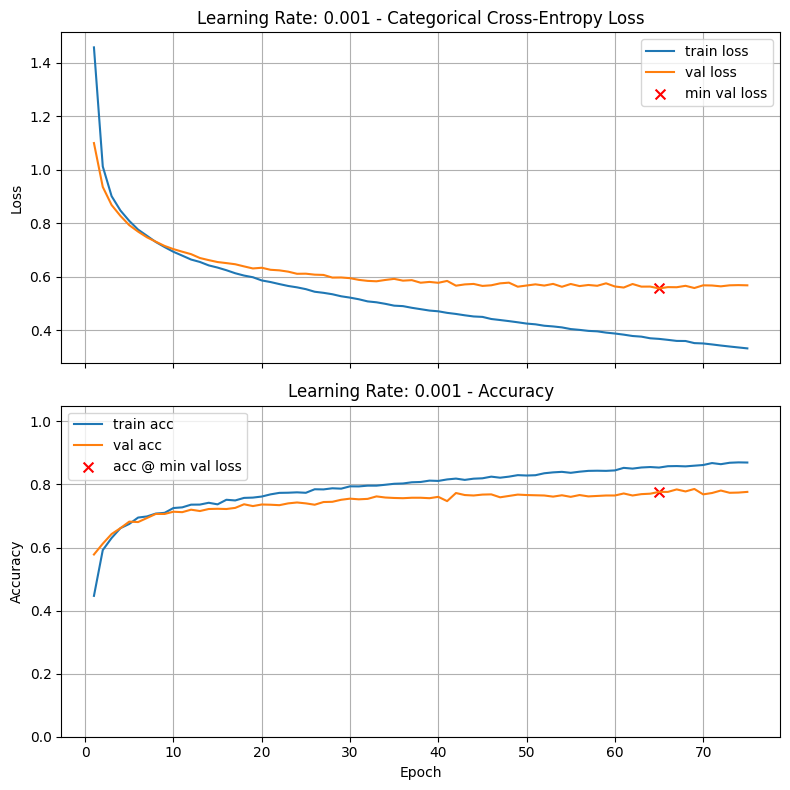

Final Training Loss:            0.3330
Final Training Accuracy:        0.8695
Final Validation Loss:          0.5686
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.5569 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.5809
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:10

Learning Rate: 0.0005



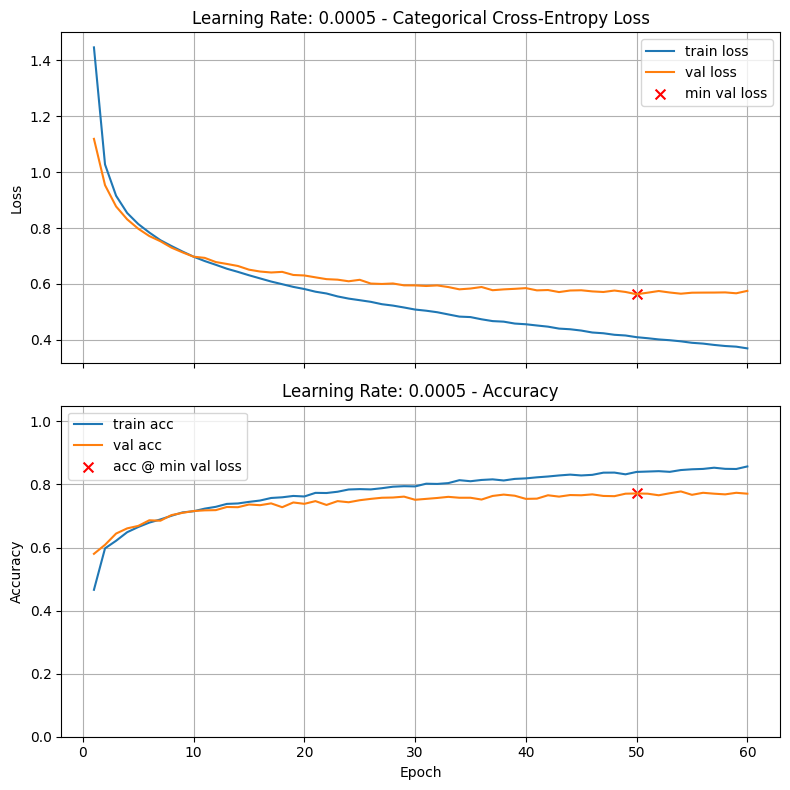

Final Training Loss:            0.3700
Final Training Accuracy:        0.8571
Final Validation Loss:          0.5754
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5633 (Epoch 50)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5733
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:09

Learning Rate: 0.0001



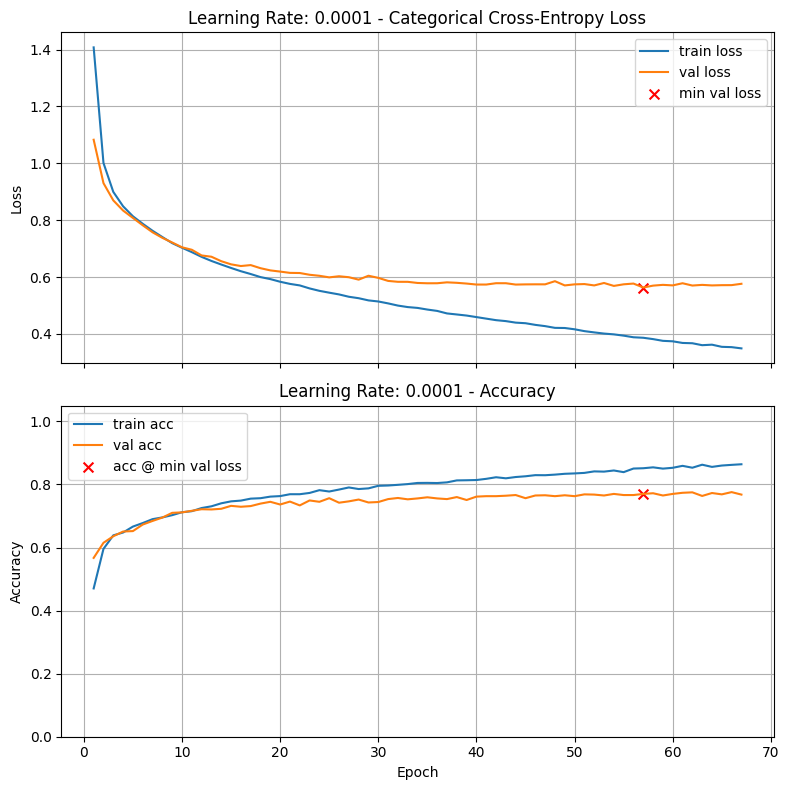

Final Training Loss:            0.3492
Final Training Accuracy:        0.8640
Final Validation Loss:          0.5763
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5632 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5801
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:09

Learning Rate: 5e-05



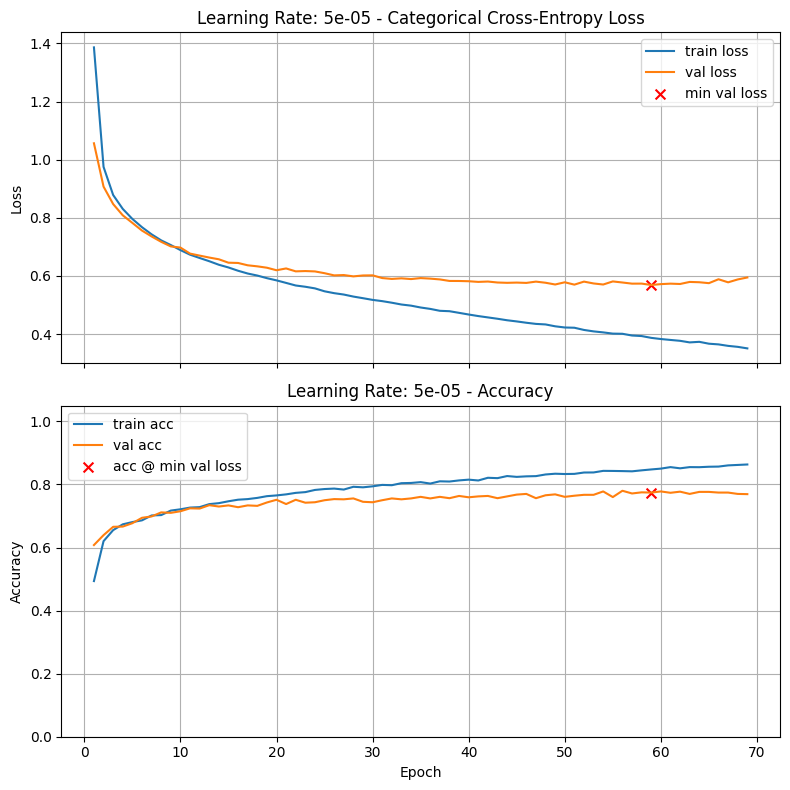

Final Training Loss:            0.3509
Final Training Accuracy:        0.8633
Final Validation Loss:          0.5948
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5690 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.5784
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:10

Learning Rate: 1e-05



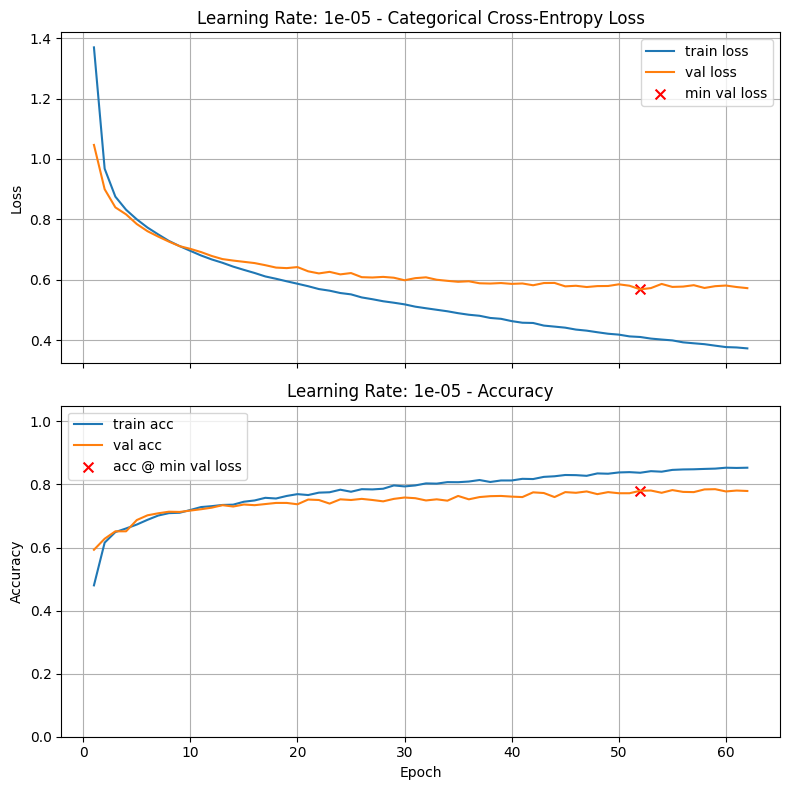

Final Training Loss:            0.3724
Final Training Accuracy:        0.8531
Final Validation Loss:          0.5720
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5680 (Epoch 52)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.5778
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.028571

Execution Time: 00:00:09


In [15]:
# Your code here. Add as many cells as you need.
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_2 = pd.DataFrame(columns=['Learning Rate', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4])

for i, lr in enumerate(learning_rate):
    model = build_model(X_train.shape[1], [ (64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Learning Rate: {lr}", verbose=0, return_history = True)
    results_2.loc[i] = [lr, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [16]:
results_2

,Learning Rate,Best Val Accuracy,Min Val Loss
0,0.001,0.776429,0.556923
1,0.0005,0.771429,0.563327
2,0.0001,0.77,0.563181
3,0.00005,0.774286,0.568961
4,0.00001,0.78,0.568025


#### Graded Questions

In [17]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = results_2['Learning Rate'][results_2['Best Val Accuracy'].idxmax()]           # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000010


In [19]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = results_2['Best Val Accuracy'].max()           # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7800


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



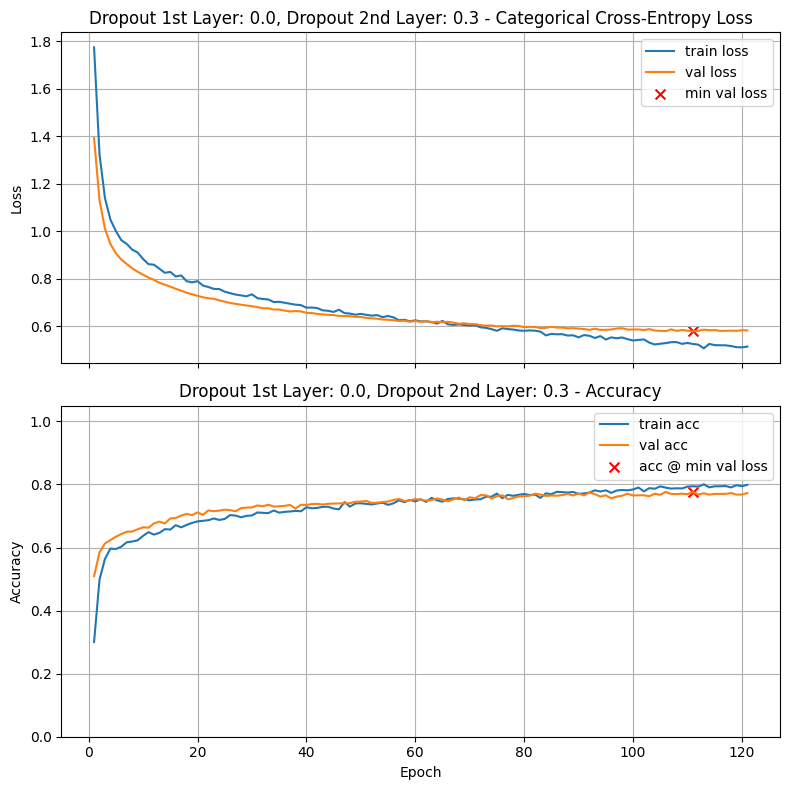

Final Training Loss:            0.5149
Final Training Accuracy:        0.7988
Final Validation Loss:          0.5830
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5789 (Epoch 111)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6060
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.029286

Execution Time: 00:00:17

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4



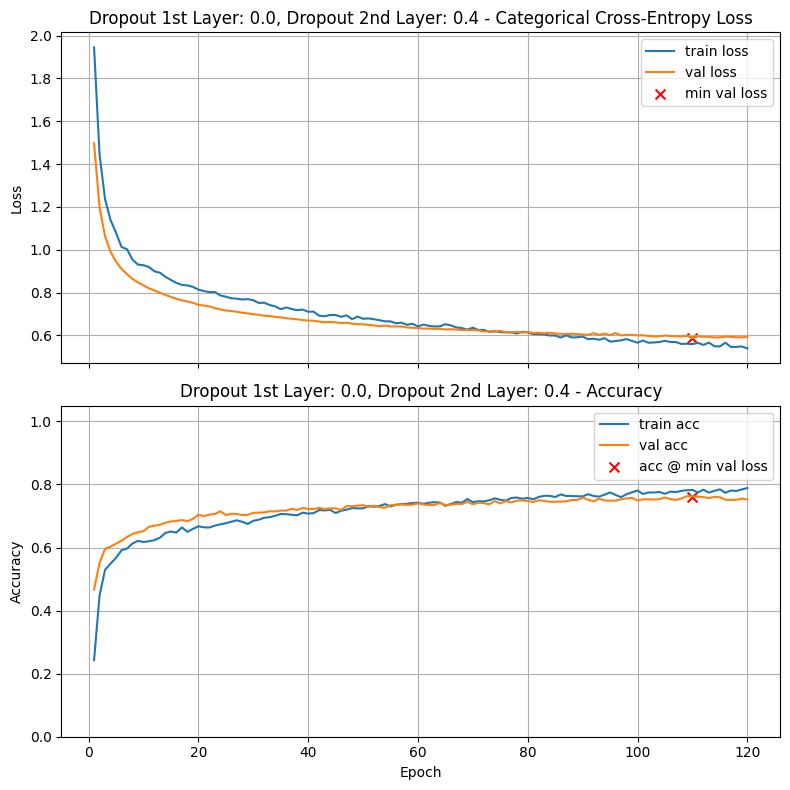

Final Training Loss:            0.5397
Final Training Accuracy:        0.7886
Final Validation Loss:          0.5932
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.5884 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6179
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:16

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5



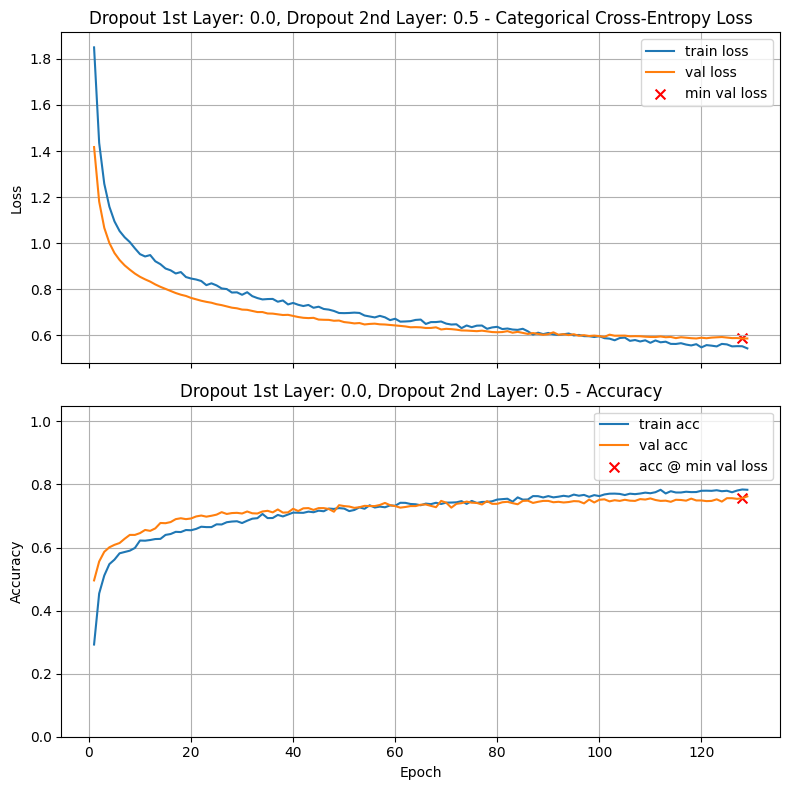

Final Training Loss:            0.5441
Final Training Accuracy:        0.7831
Final Validation Loss:          0.5871
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5870 (Epoch 128)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.6089
Test Accuracy: 0.7464

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:17

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3



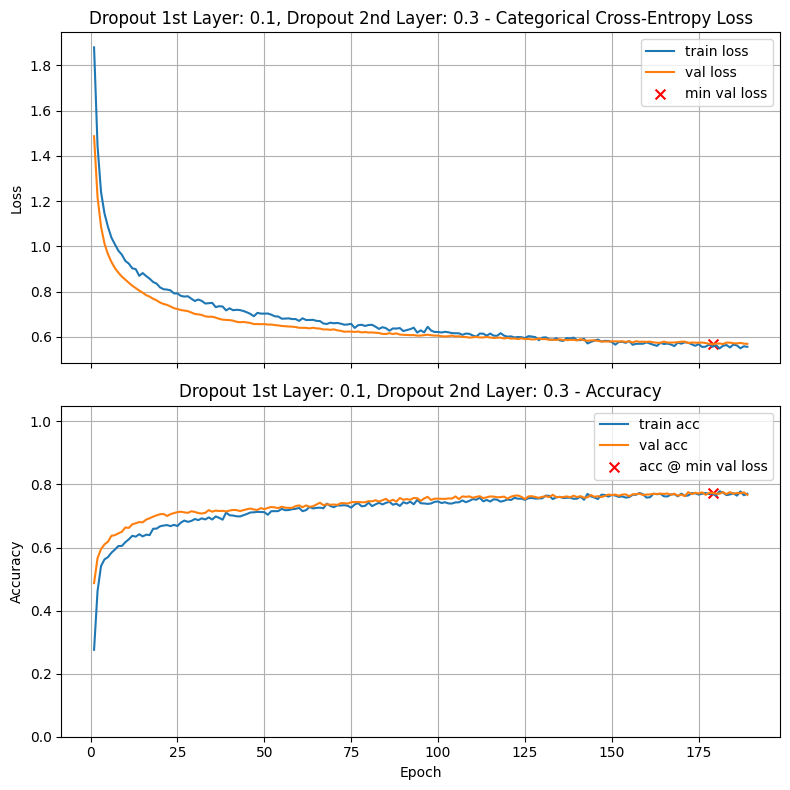

Final Training Loss:            0.5564
Final Training Accuracy:        0.7705
Final Validation Loss:          0.5695
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5673 (Epoch 179)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5923
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:27

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4



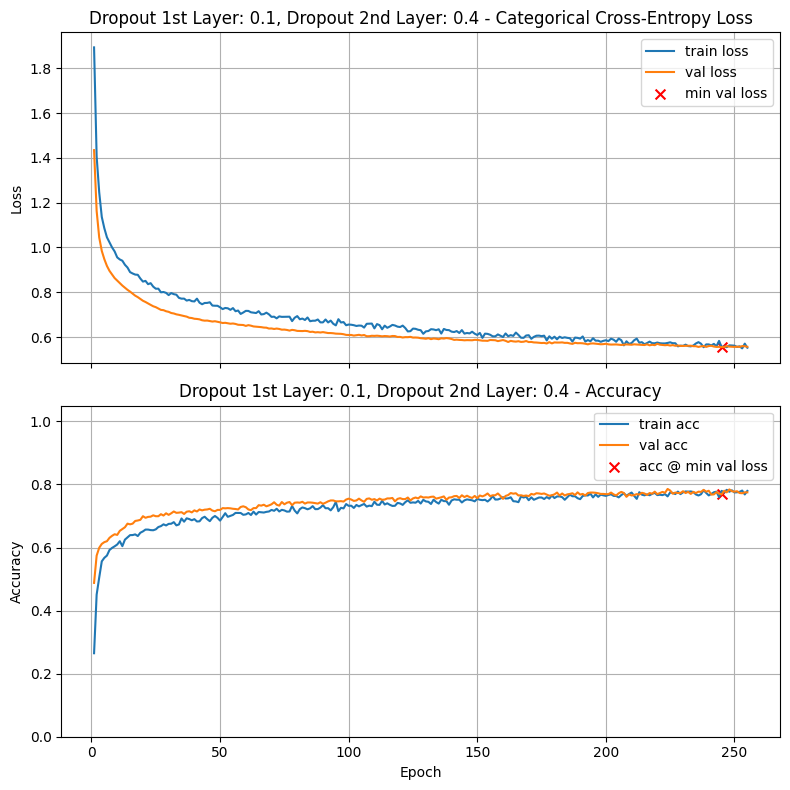

Final Training Loss:            0.5524
Final Training Accuracy:        0.7795
Final Validation Loss:          0.5566
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5552 (Epoch 245)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.5932
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:33

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5



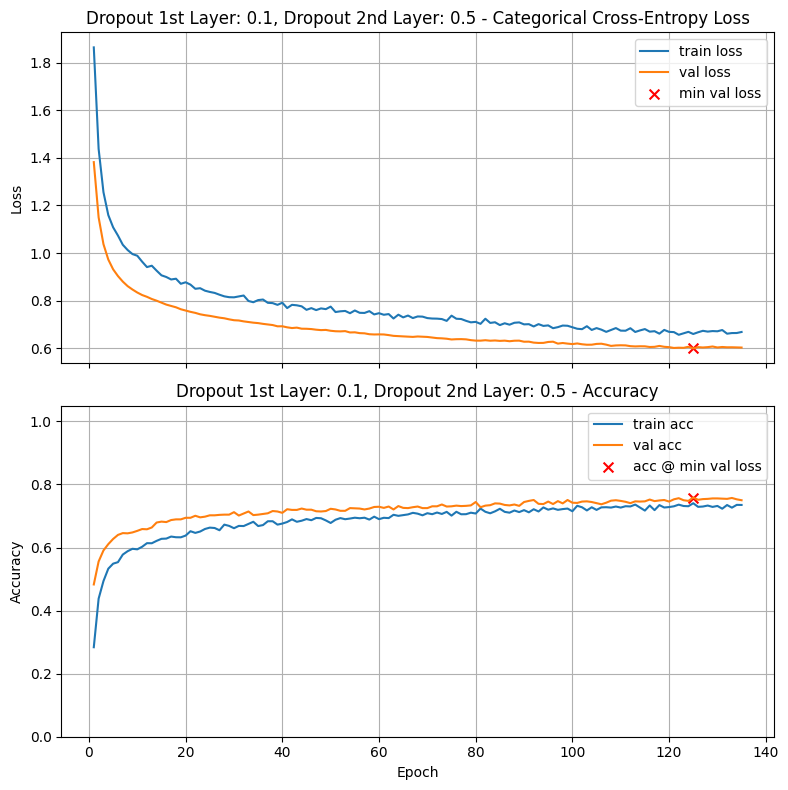

Final Training Loss:            0.6678
Final Training Accuracy:        0.7350
Final Validation Loss:          0.6023
Final Validation Accuracy:      0.7500
Minimum Validation Loss:        0.5988 (Epoch 125)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.6356
Test Accuracy: 0.7357

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:18

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3



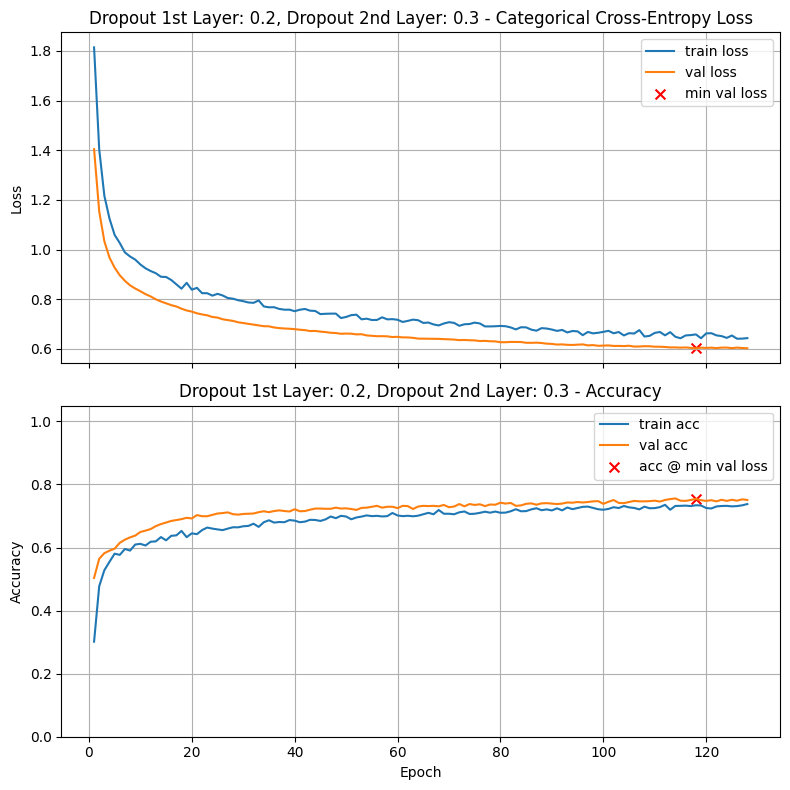

Final Training Loss:            0.6438
Final Training Accuracy:        0.7379
Final Validation Loss:          0.6028
Final Validation Accuracy:      0.7507
Minimum Validation Loss:        0.6024 (Epoch 118)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6363
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:17

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4



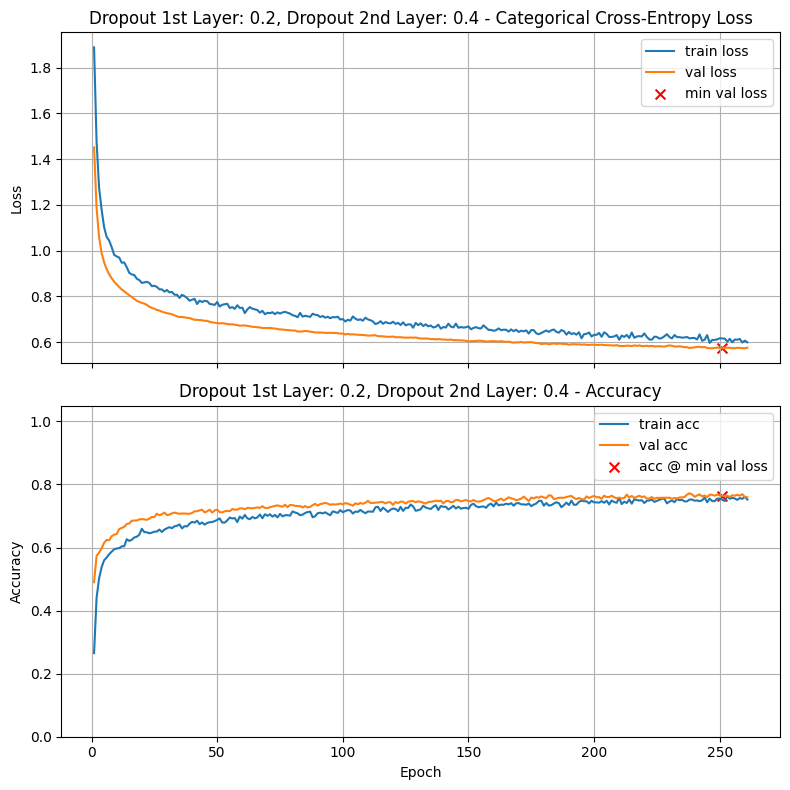

Final Training Loss:            0.5993
Final Training Accuracy:        0.7521
Final Validation Loss:          0.5755
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.5726 (Epoch 251)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6090
Test Accuracy: 0.7464

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:34

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5



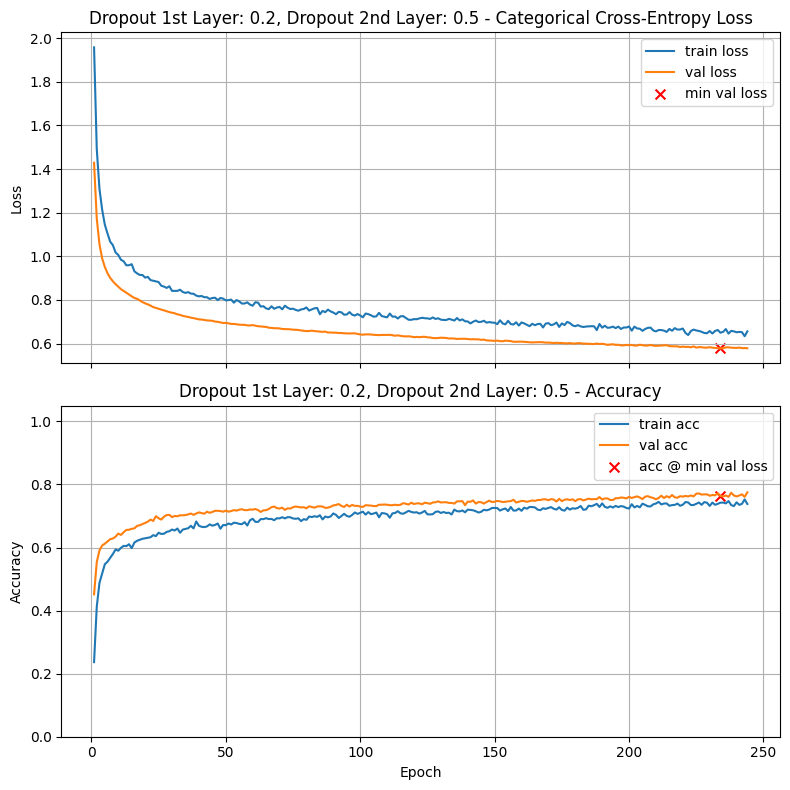

Final Training Loss:            0.6555
Final Training Accuracy:        0.7381
Final Validation Loss:          0.5782
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5777 (Epoch 234)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6218
Test Accuracy: 0.7393

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:32


In [21]:
# Your code here. Add as many cells as you need.
lr_3 = 5e-4
af_3 = 'tanh'

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

results_3 = pd.DataFrame(columns=['First Dropout', 'Second Dropout', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, drop_out_1st in enumerate(drop_out_1st_layer):
    for j, drop_out_2nd in enumerate(drop_out_2nd_layer):
        model = build_model(X_train.shape[1], [ (64, af_3, 0.0, drop_out_1st), (32, af_3, 0.0, drop_out_2nd)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_3, title=f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}", verbose=0, return_history = True)
        results_3.iloc[i * 3 + j] = [drop_out_1st, drop_out_2nd, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [22]:
results_3

,First Dropout,Second Dropout,Best Val Accuracy,Min Val Loss
0,0.0,0.3,0.776429,0.578931
1,0.0,0.4,0.761429,0.588413
2,0.0,0.5,0.756429,0.587014
3,0.1,0.3,0.772857,0.567312
4,0.1,0.4,0.768571,0.555235
5,0.1,0.5,0.758571,0.598795
6,0.2,0.3,0.754286,0.602434
7,0.2,0.4,0.764286,0.57256
8,0.2,0.5,0.763571,0.57767


In [23]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (results_3['First Dropout'].loc[results_3['Best Val Accuracy'].idxmax()], results_3['Second Dropout'].loc[results_3['Best Val Accuracy'].idxmax()])             # Replace (0.0,0.0) with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.3)


In [25]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = results_3['Best Val Accuracy'].max()             # Replace 0.0 with your answer

In [26]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7764


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Regularization: 0.0001, 0.0001



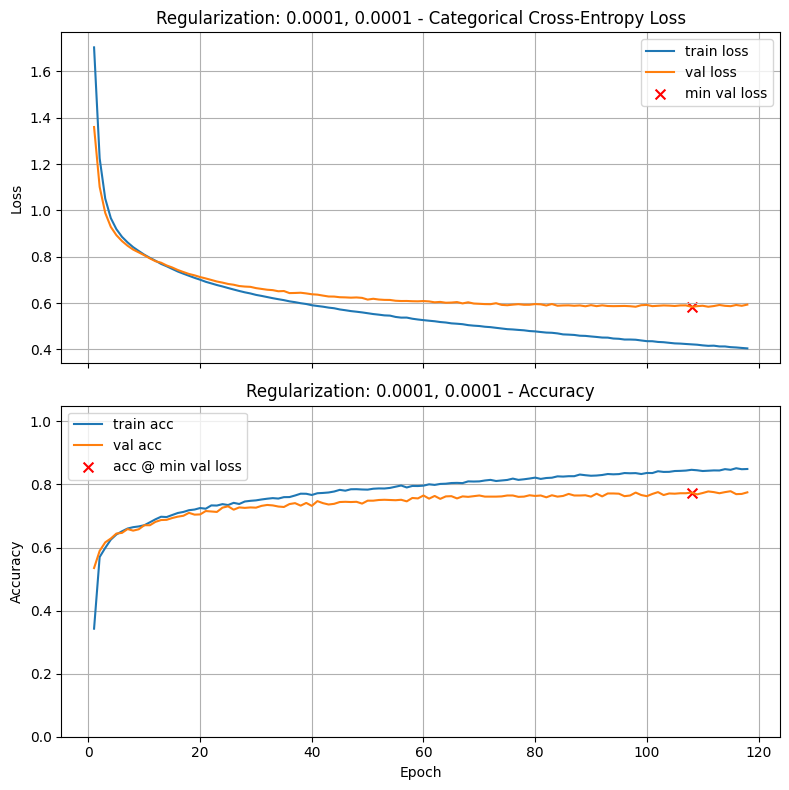

Final Training Loss:            0.4044
Final Training Accuracy:        0.8490
Final Validation Loss:          0.5933
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5838 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.5931
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:15

Regularization: 0.0001, 0.001



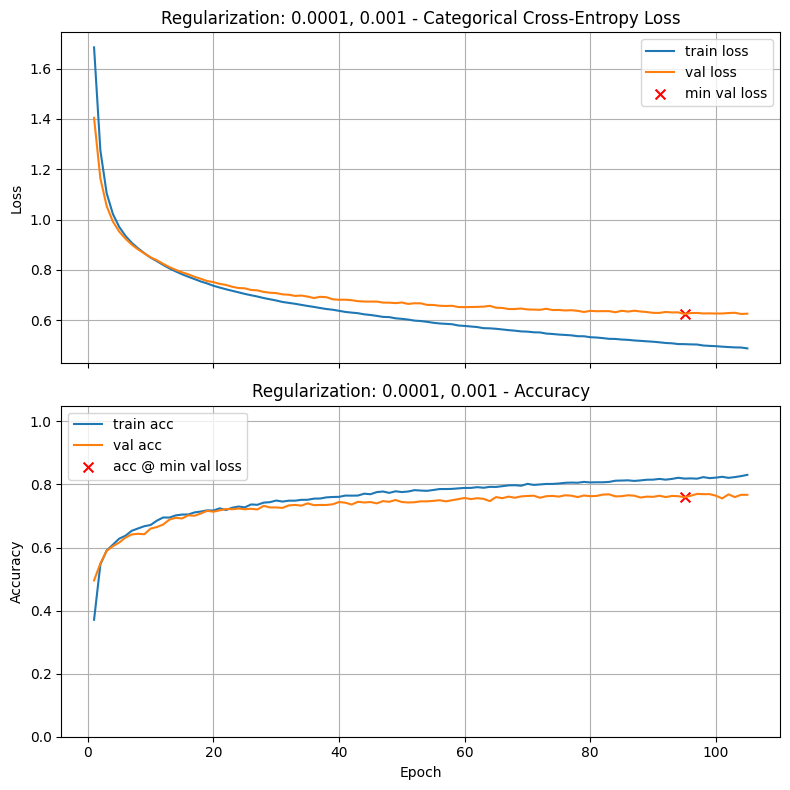

Final Training Loss:            0.4876
Final Training Accuracy:        0.8305
Final Validation Loss:          0.6256
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6242 (Epoch 95)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.6321
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:13

Regularization: 0.0001, 0.01



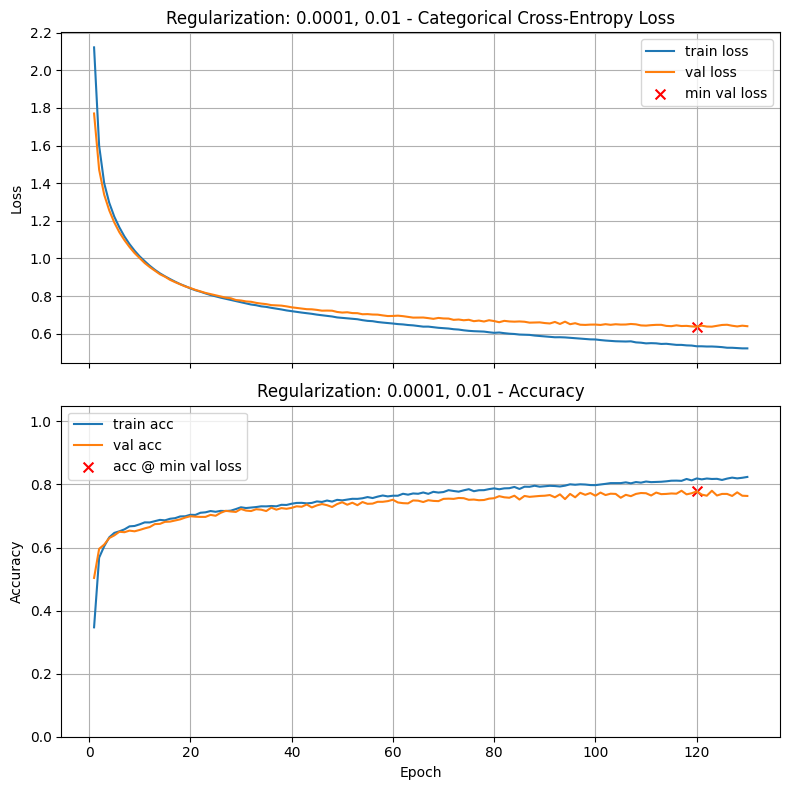

Final Training Loss:            0.5217
Final Training Accuracy:        0.8238
Final Validation Loss:          0.6396
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6369 (Epoch 120)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.6691
Test Accuracy: 0.7457

Validation-Test Gap (accuracy): 0.032143

Execution Time: 00:00:16

Regularization: 0.001, 0.0001



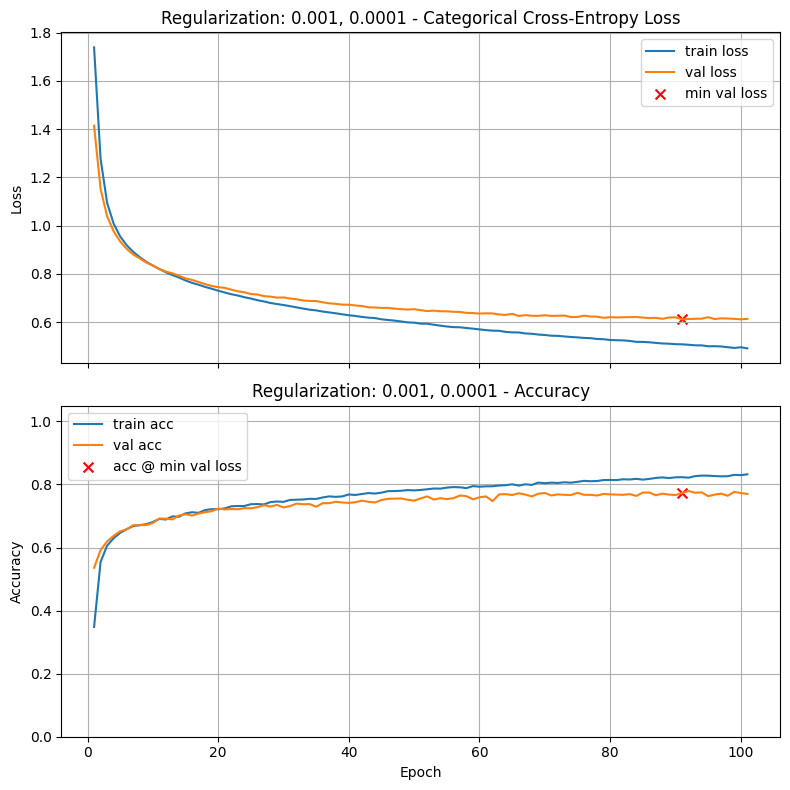

Final Training Loss:            0.4906
Final Training Accuracy:        0.8321
Final Validation Loss:          0.6130
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6112 (Epoch 91)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.6309
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:13

Regularization: 0.001, 0.001



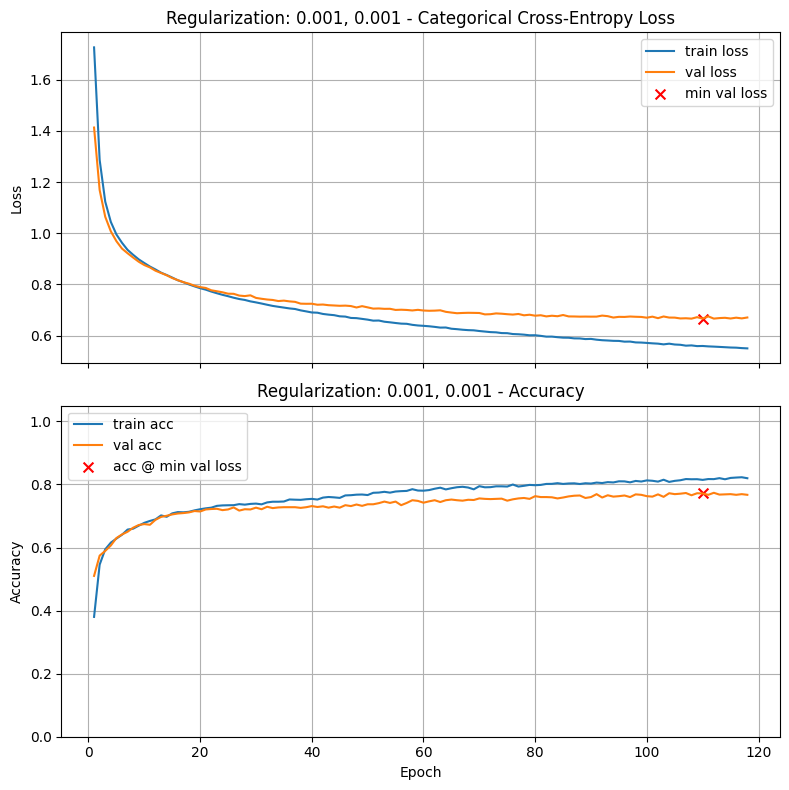

Final Training Loss:            0.5501
Final Training Accuracy:        0.8198
Final Validation Loss:          0.6708
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6663 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6747
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:15

Regularization: 0.001, 0.01



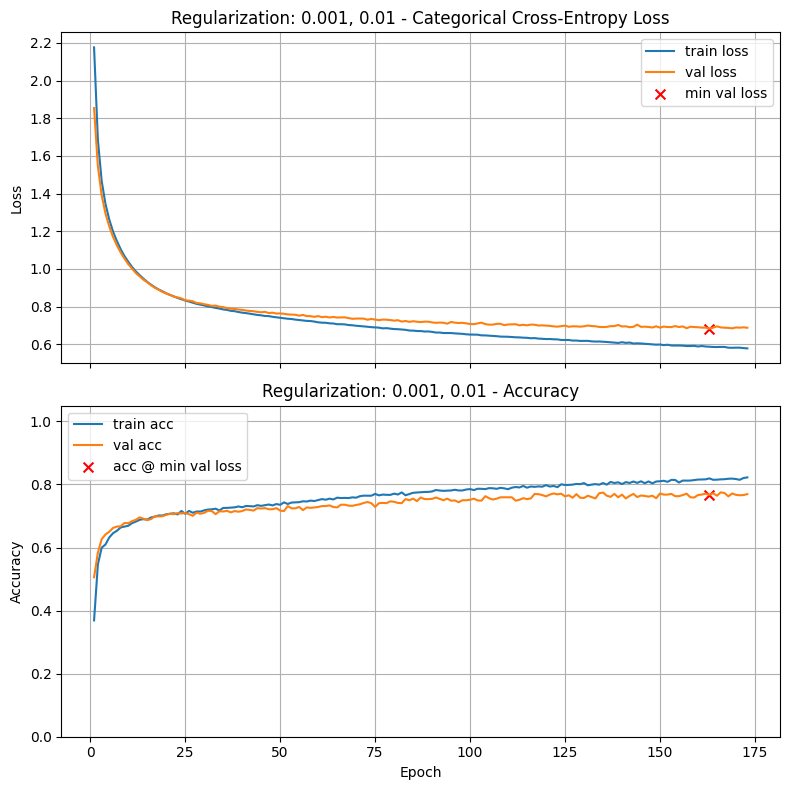

Final Training Loss:            0.5782
Final Training Accuracy:        0.8224
Final Validation Loss:          0.6878
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.6832 (Epoch 163)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6871
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:22

Regularization: 0.01, 0.0001



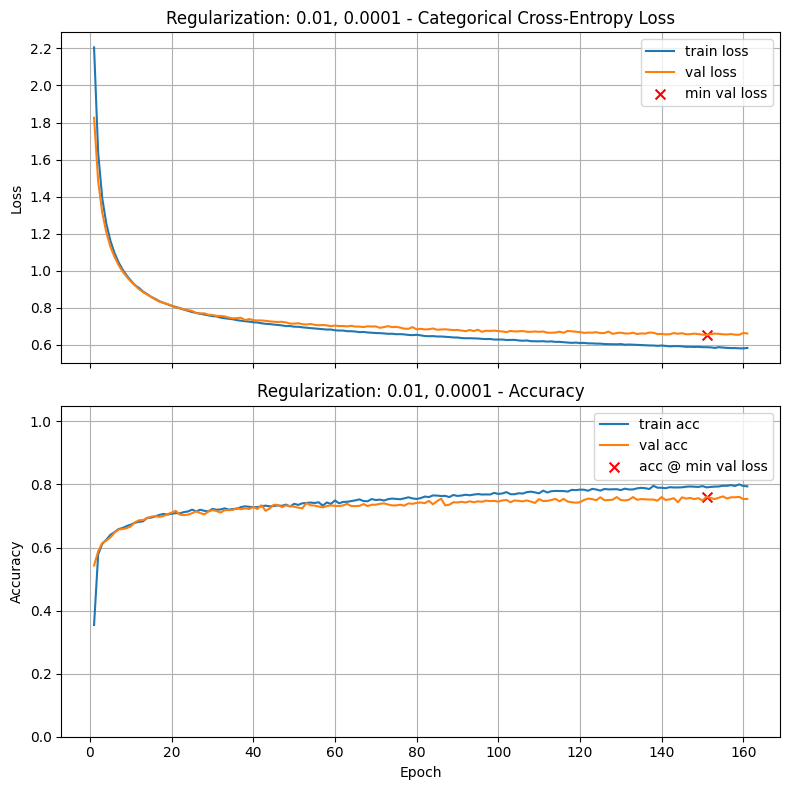

Final Training Loss:            0.5837
Final Training Accuracy:        0.7940
Final Validation Loss:          0.6617
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6533 (Epoch 151)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6882
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:20

Regularization: 0.01, 0.001



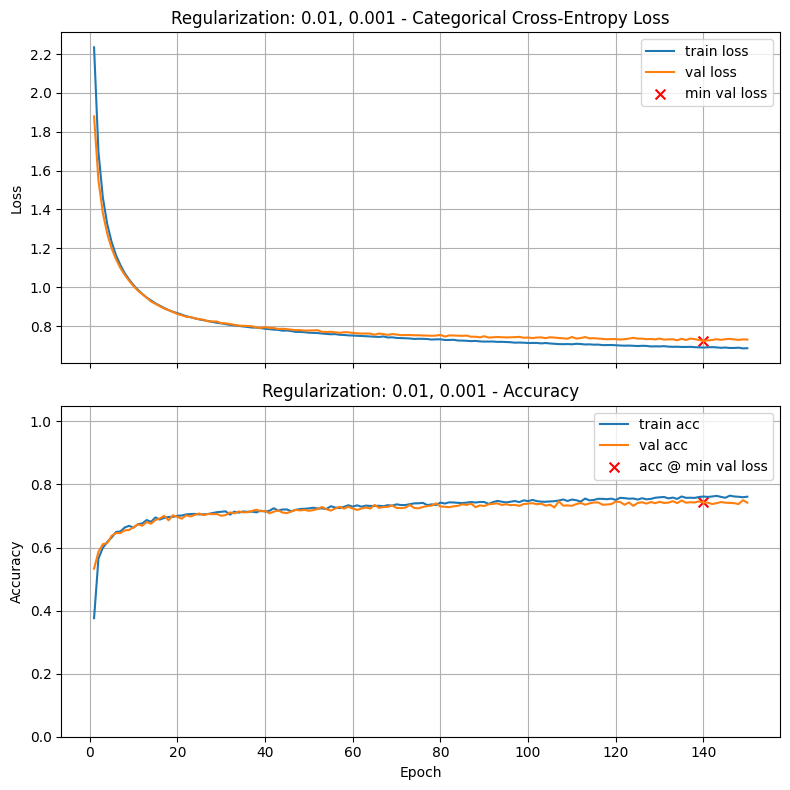

Final Training Loss:            0.6859
Final Training Accuracy:        0.7612
Final Validation Loss:          0.7304
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.7236 (Epoch 140)
Validation Accuracy @ Min Loss: 0.7429

Test Loss: 0.7357
Test Accuracy: 0.7357

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:19

Regularization: 0.01, 0.01



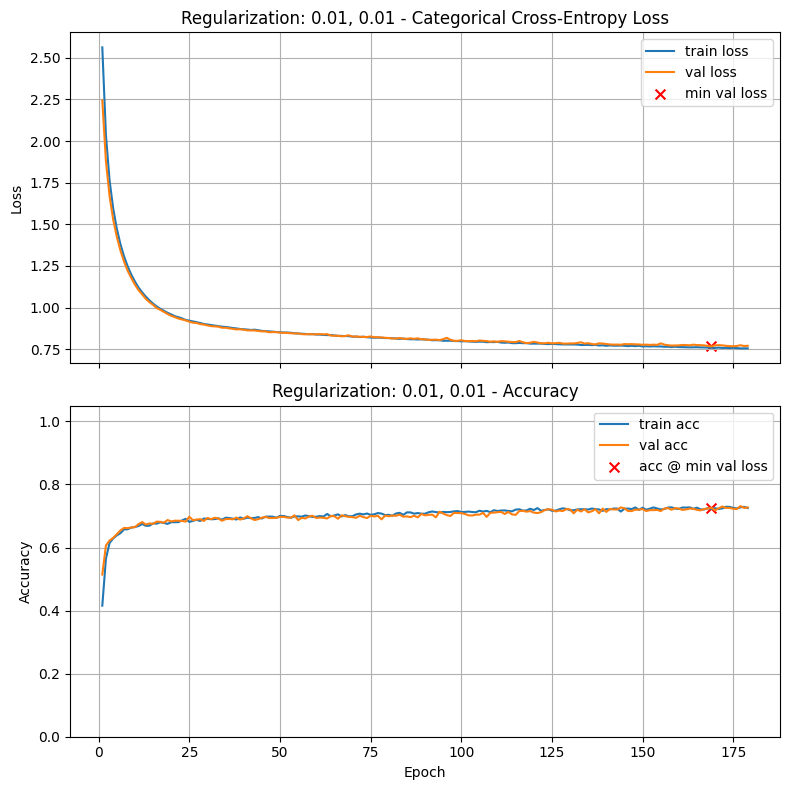

Final Training Loss:            0.7557
Final Training Accuracy:        0.7252
Final Validation Loss:          0.7710
Final Validation Accuracy:      0.7271
Minimum Validation Loss:        0.7673 (Epoch 169)
Validation Accuracy @ Min Loss: 0.7264

Test Loss: 0.7953
Test Accuracy: 0.7157

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:22


In [27]:
# Your code here. Add as many cells as you need. 
lr_4 = 5e-4
af_4 = 'tanh'

regularization_4 = [1e-4, 1e-3, 1e-2]

results_4 = pd.DataFrame(columns=['First Layer Reg', 'Second Layer Reg', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, reg_i in enumerate(regularization_4):
    for j, reg_j in enumerate(regularization_4):
        model = build_model(X_train.shape[1], [ (64, af_4, reg_i, 0.0), (32, af_4, reg_j, 0.0)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_4, title=f"Regularization: {reg_i}, {reg_j}", verbose=0, return_history = True)
        results_4.iloc[i * 3 + j] = [reg_i, reg_j, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [28]:
results_4

,First Layer Reg,Second Layer Reg,Best Val Accuracy,Min Val Loss
0,0.0001,0.0001,0.774286,0.583793
1,0.0001,0.001,0.759286,0.624207
2,0.0001,0.01,0.777857,0.636937
3,0.001,0.0001,0.772857,0.611153
4,0.001,0.001,0.771429,0.666335
5,0.001,0.01,0.767143,0.683153
6,0.01,0.0001,0.760714,0.653262
7,0.01,0.001,0.742857,0.7236
8,0.01,0.01,0.726429,0.767288


In [29]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (results_4['First Layer Reg'].iloc[results_4['Best Val Accuracy'].idxmax()], results_4['Second Layer Reg'].iloc[results_4['Best Val Accuracy'].idxmax()])             # Replace (0.0,0.0) with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.01)


In [31]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = results_4['Best Val Accuracy'].max()             # Replace 0.0 with your answer

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7779


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Regularization: 0.0001, 0.0001



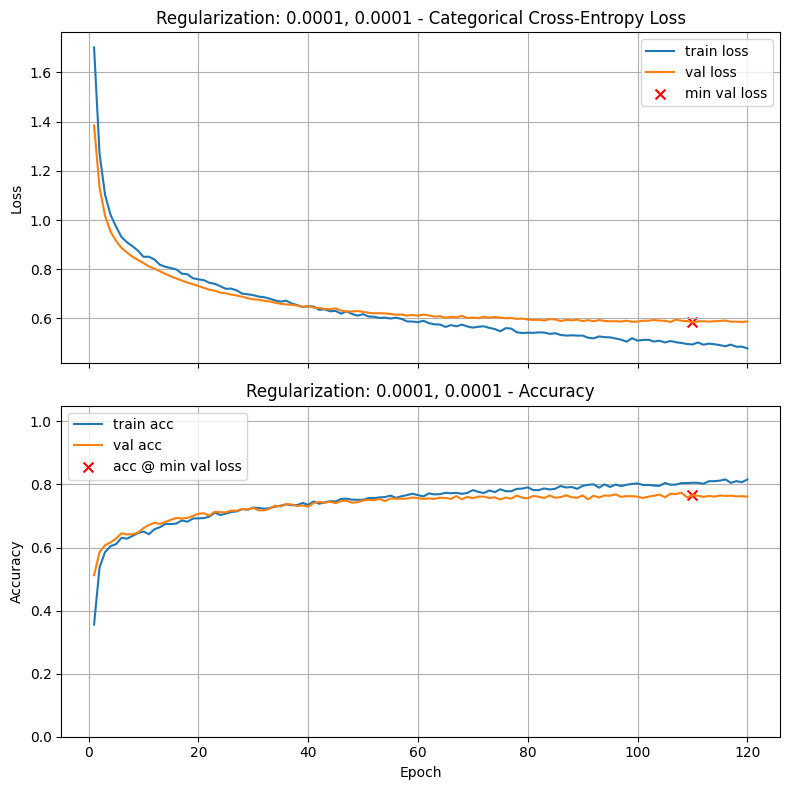

Final Training Loss:            0.4784
Final Training Accuracy:        0.8157
Final Validation Loss:          0.5880
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5846 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6165
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:16

Regularization: 0.0001, 0.001



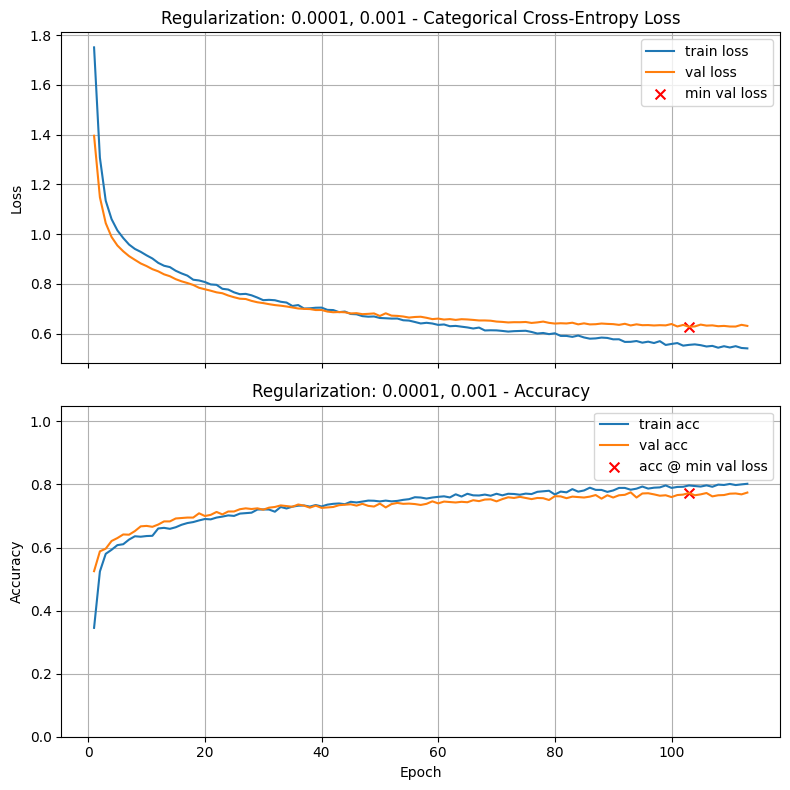

Final Training Loss:            0.5402
Final Training Accuracy:        0.8021
Final Validation Loss:          0.6306
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.6271 (Epoch 103)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.6439
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:14

Regularization: 0.0001, 0.01



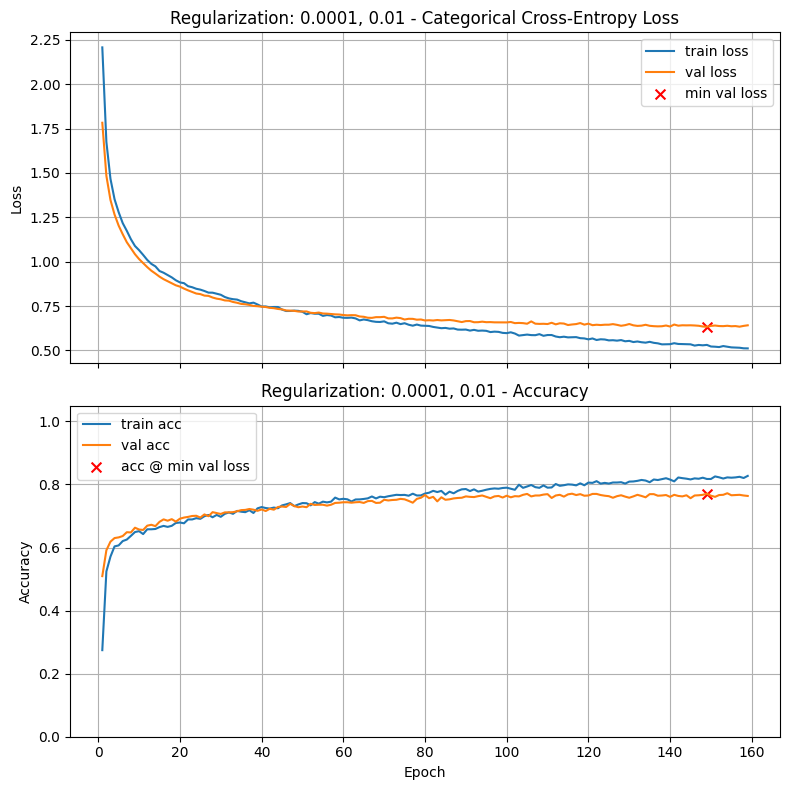

Final Training Loss:            0.5116
Final Training Accuracy:        0.8271
Final Validation Loss:          0.6416
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6335 (Epoch 149)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6573
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:20

Regularization: 0.001, 0.0001



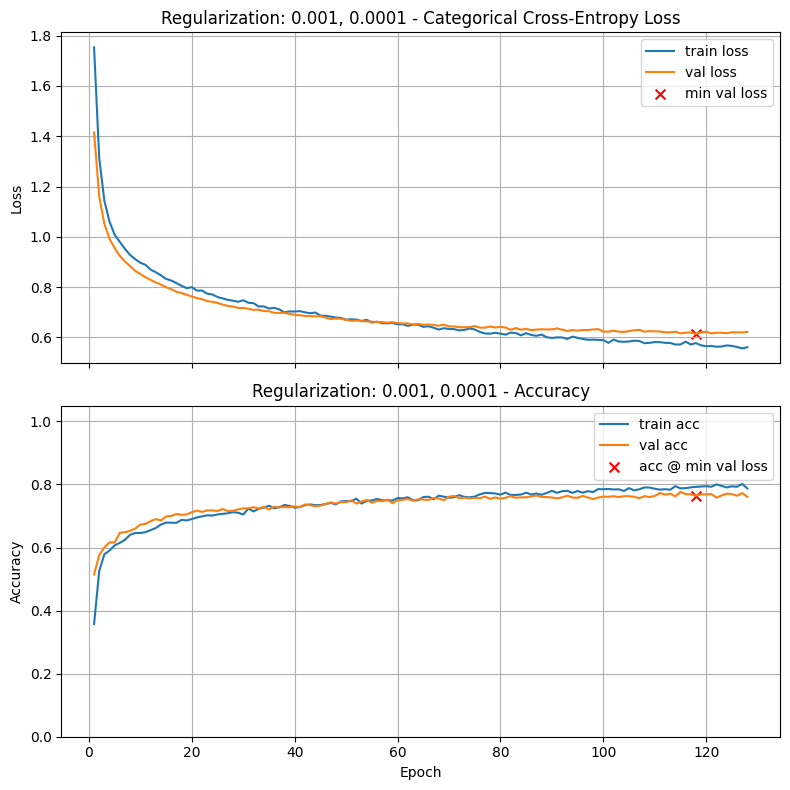

Final Training Loss:            0.5604
Final Training Accuracy:        0.7874
Final Validation Loss:          0.6215
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.6137 (Epoch 118)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6471
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:17

Regularization: 0.001, 0.001



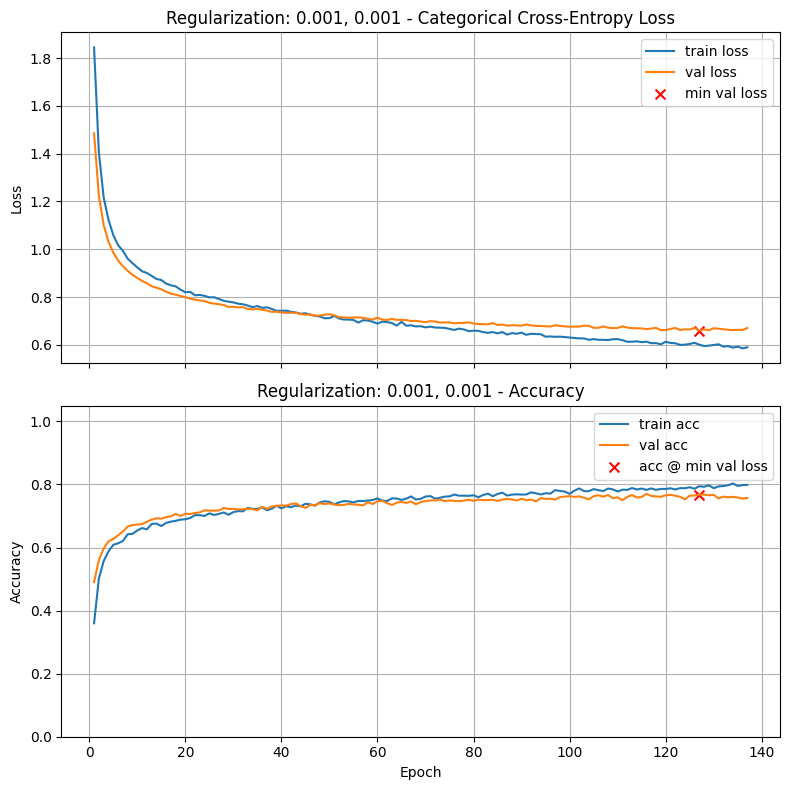

Final Training Loss:            0.5896
Final Training Accuracy:        0.7988
Final Validation Loss:          0.6705
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.6594 (Epoch 127)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6859
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:18

Regularization: 0.001, 0.01



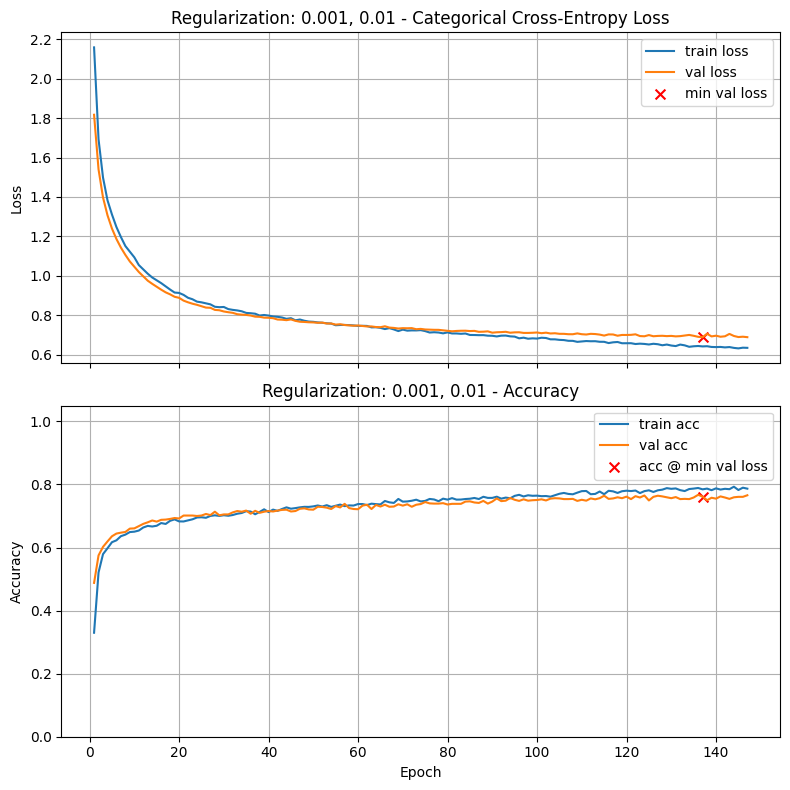

Final Training Loss:            0.6354
Final Training Accuracy:        0.7867
Final Validation Loss:          0.6896
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6894 (Epoch 137)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.7196
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:19

Regularization: 0.01, 0.0001



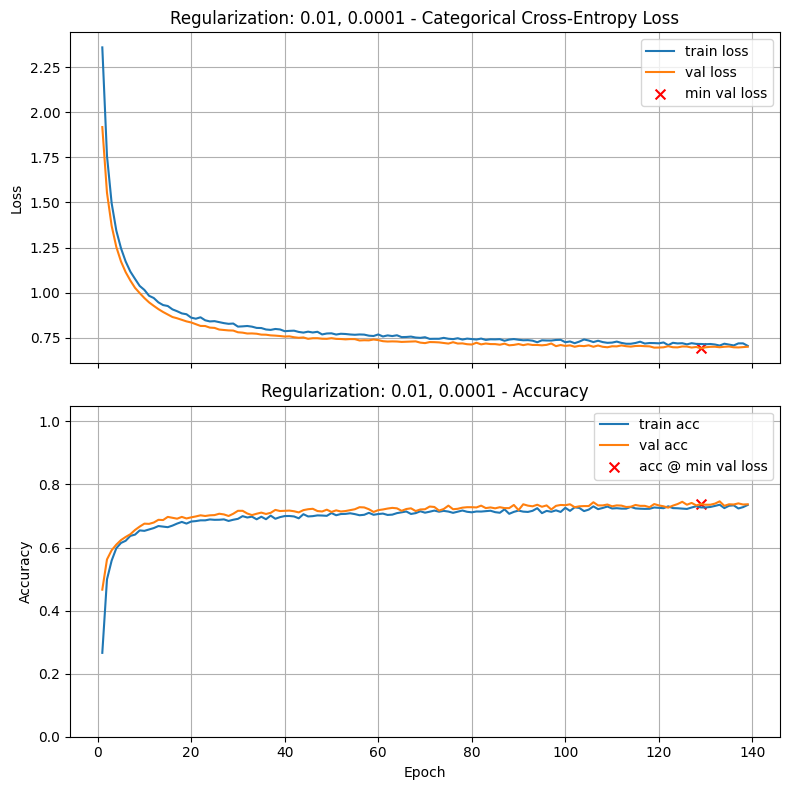

Final Training Loss:            0.7059
Final Training Accuracy:        0.7350
Final Validation Loss:          0.7010
Final Validation Accuracy:      0.7371
Minimum Validation Loss:        0.6919 (Epoch 129)
Validation Accuracy @ Min Loss: 0.7379

Test Loss: 0.7140
Test Accuracy: 0.7264

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:18

Regularization: 0.01, 0.001



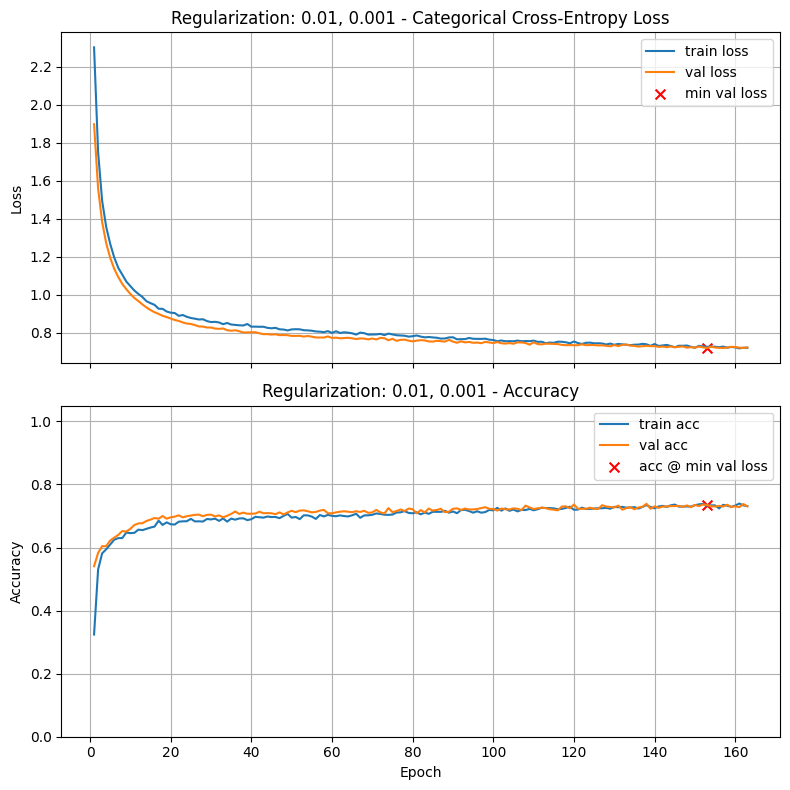

Final Training Loss:            0.7220
Final Training Accuracy:        0.7314
Final Validation Loss:          0.7238
Final Validation Accuracy:      0.7307
Minimum Validation Loss:        0.7205 (Epoch 153)
Validation Accuracy @ Min Loss: 0.7350

Test Loss: 0.7419
Test Accuracy: 0.7243

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:21

Regularization: 0.01, 0.01



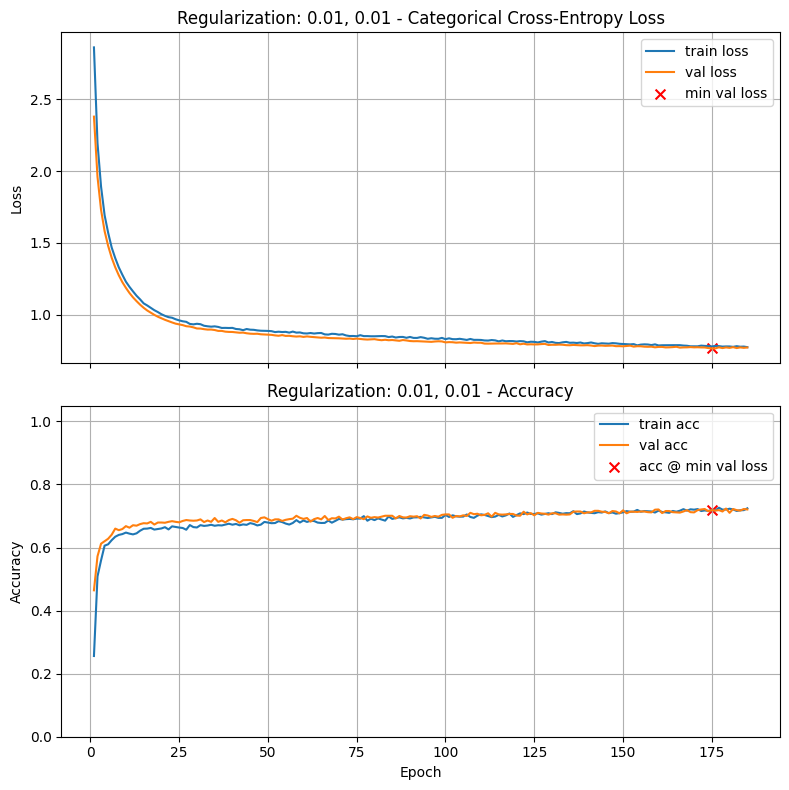

Final Training Loss:            0.7741
Final Training Accuracy:        0.7243
Final Validation Loss:          0.7718
Final Validation Accuracy:      0.7207
Minimum Validation Loss:        0.7655 (Epoch 175)
Validation Accuracy @ Min Loss: 0.7186

Test Loss: 0.7945
Test Accuracy: 0.7136

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:23


In [33]:
# Your code here. Add as many cells as you need.
lr_5 = 5e-4
af_5 = 'tanh'

regularization_5 = [1e-4, 1e-3, 1e-2]

drop_out_1st_layer_5 = 0.0
drop_out_2nd_layer_5 = 0.2

results_5 = pd.DataFrame(columns=['First Layer Reg', 'Second Layer Reg', 'First Dropout', 'Second Dropout', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, reg_i in enumerate(regularization_5):
    for j, reg_j in enumerate(regularization_5):
        model = build_model(X_train.shape[1], [ (64, af_5, reg_i, drop_out_1st_layer_5), (32, af_5, reg_j, drop_out_2nd_layer_5)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr_5, title=f"Regularization: {reg_i}, {reg_j}", verbose=0, return_history = True)
        results_5.iloc[i * 3 + j] = [reg_i, reg_j, drop_out_1st_layer_5, drop_out_2nd_layer_5, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [34]:
results_5

,First Layer Reg,Second Layer Reg,First Dropout,Second Dropout,Best Val Accuracy,Min Val Loss
0,0.0001,0.0001,0.0,0.2,0.765714,0.584617
1,0.0001,0.001,0.0,0.2,0.772857,0.627137
2,0.0001,0.01,0.0,0.2,0.770714,0.633504
3,0.001,0.0001,0.0,0.2,0.764286,0.61371
4,0.001,0.001,0.0,0.2,0.767857,0.659413
5,0.001,0.01,0.0,0.2,0.761429,0.689357
6,0.01,0.0001,0.0,0.2,0.737857,0.691916
7,0.01,0.001,0.0,0.2,0.735,0.720498
8,0.01,0.01,0.0,0.2,0.718571,0.765507


In [35]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = results_5['Best Val Accuracy'].max()            # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7729


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Decay Rate: 0.9



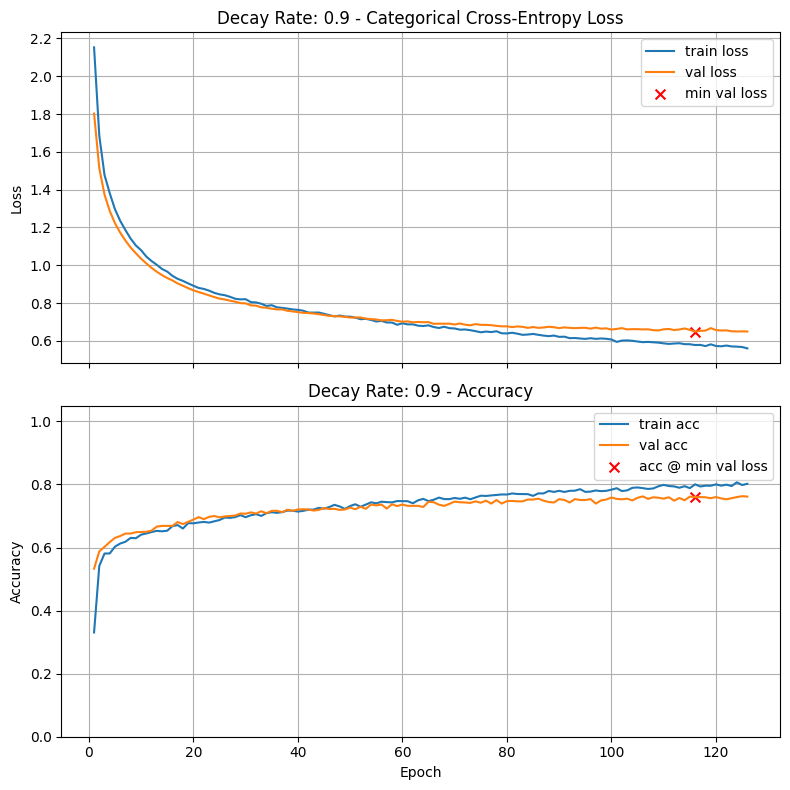

Final Training Loss:            0.5601
Final Training Accuracy:        0.8021
Final Validation Loss:          0.6495
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.6490 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6629
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:17

Decay Rate: 0.91



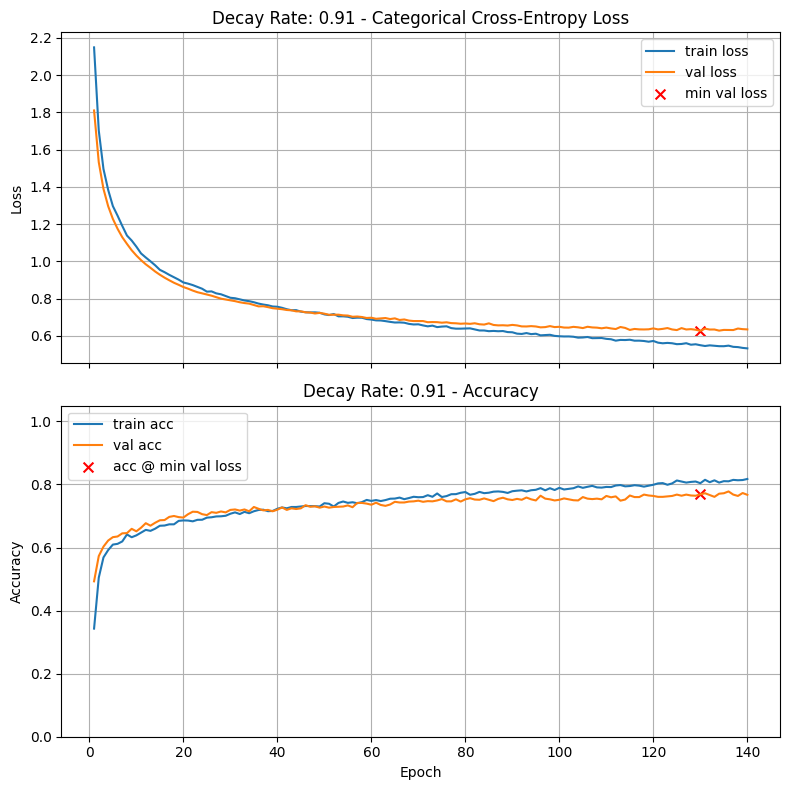

Final Training Loss:            0.5327
Final Training Accuracy:        0.8174
Final Validation Loss:          0.6346
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6271 (Epoch 130)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6530
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:20

Decay Rate: 0.92



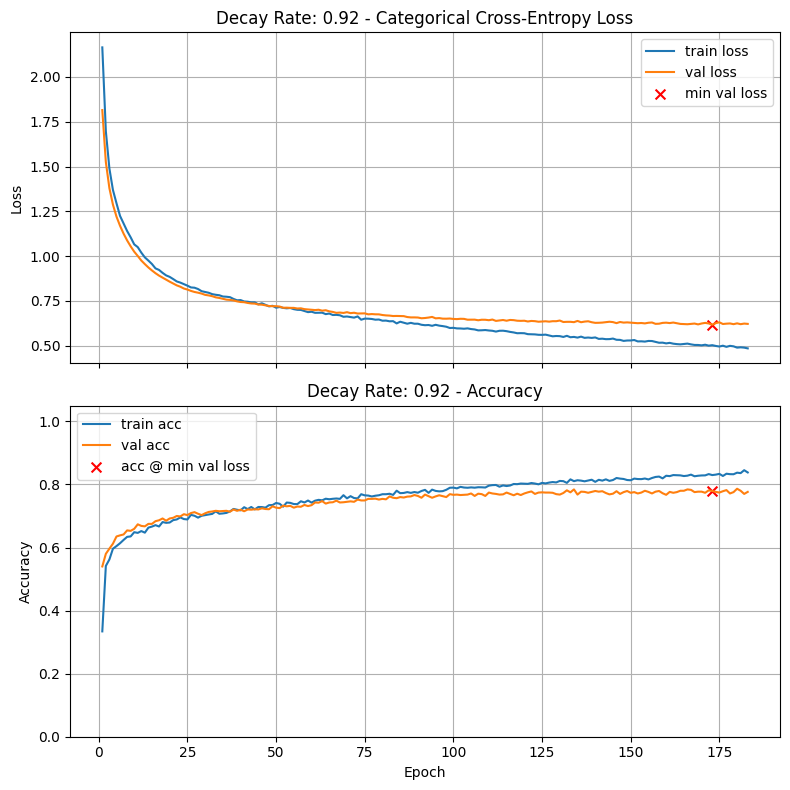

Final Training Loss:            0.4852
Final Training Accuracy:        0.8381
Final Validation Loss:          0.6219
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.6175 (Epoch 173)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6550
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:26

Decay Rate: 0.93



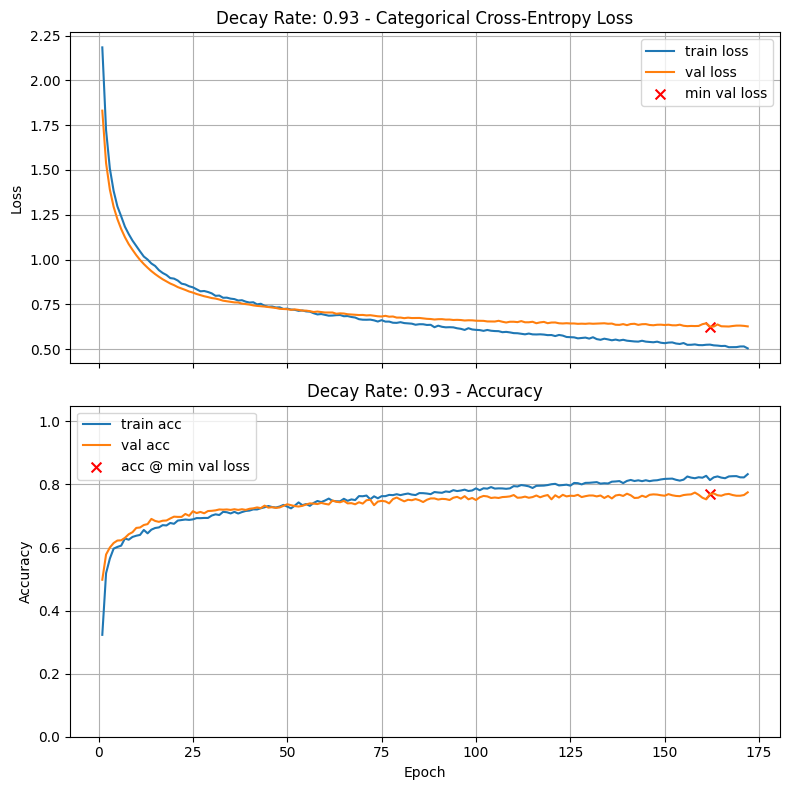

Final Training Loss:            0.5052
Final Training Accuracy:        0.8326
Final Validation Loss:          0.6278
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6263 (Epoch 162)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6553
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:23

Decay Rate: 0.9400000000000001



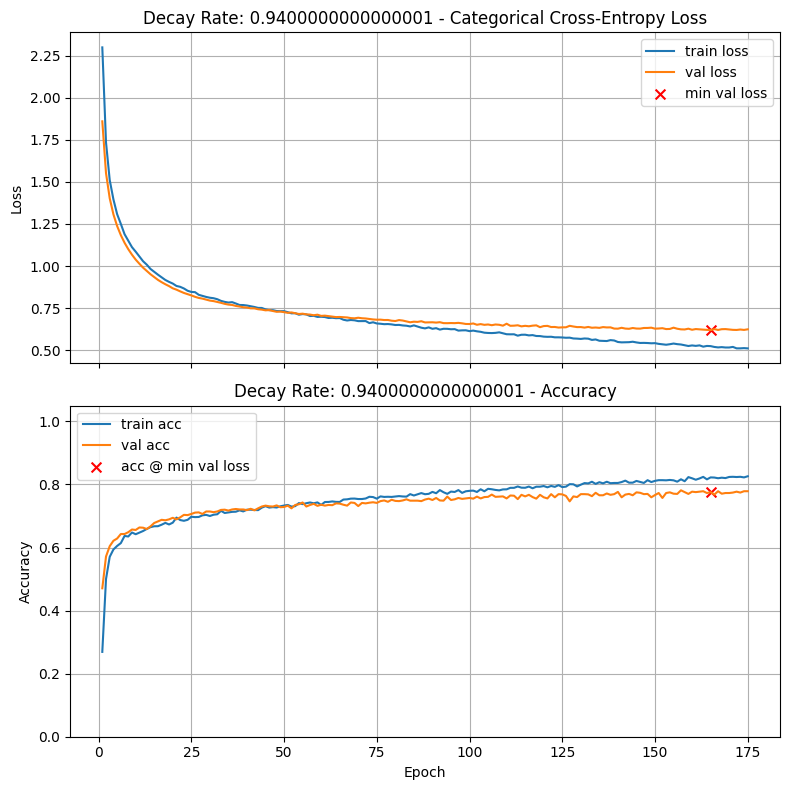

Final Training Loss:            0.5110
Final Training Accuracy:        0.8260
Final Validation Loss:          0.6242
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.6197 (Epoch 165)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6483
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:22

Decay Rate: 0.95



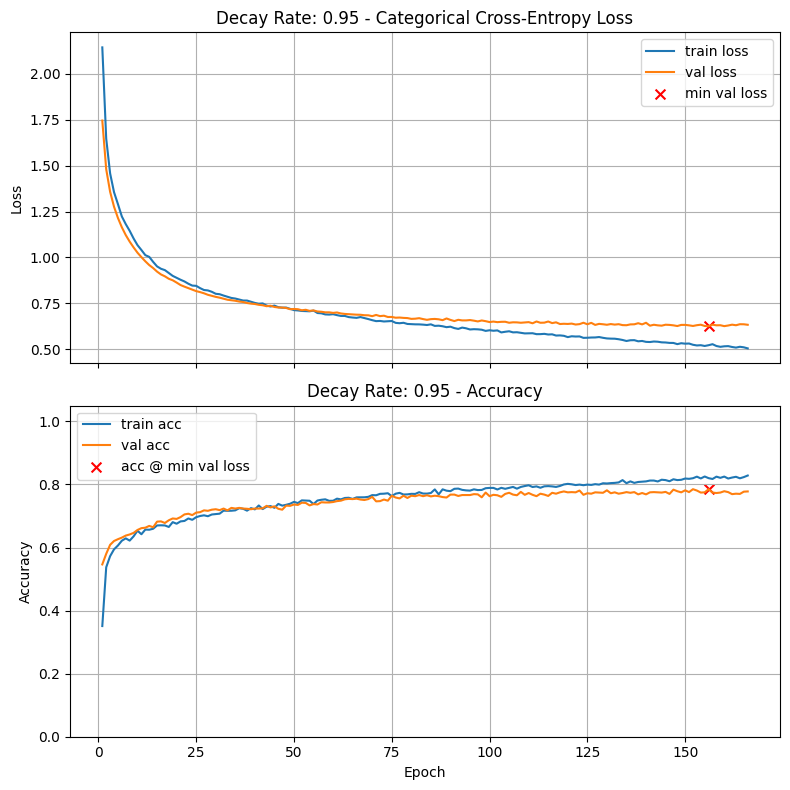

Final Training Loss:            0.5051
Final Training Accuracy:        0.8283
Final Validation Loss:          0.6336
Final Validation Accuracy:      0.7779
Minimum Validation Loss:        0.6258 (Epoch 156)
Validation Accuracy @ Min Loss: 0.7850

Test Loss: 0.6468
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:21

Decay Rate: 0.96



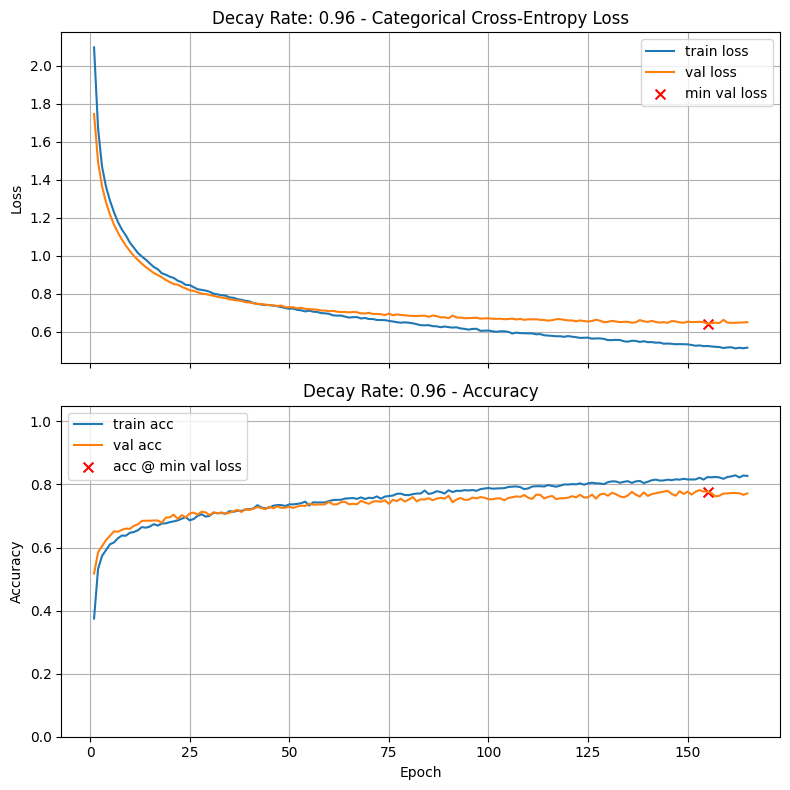

Final Training Loss:            0.5157
Final Training Accuracy:        0.8271
Final Validation Loss:          0.6495
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.6424 (Epoch 155)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6540
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:21

Decay Rate: 0.97



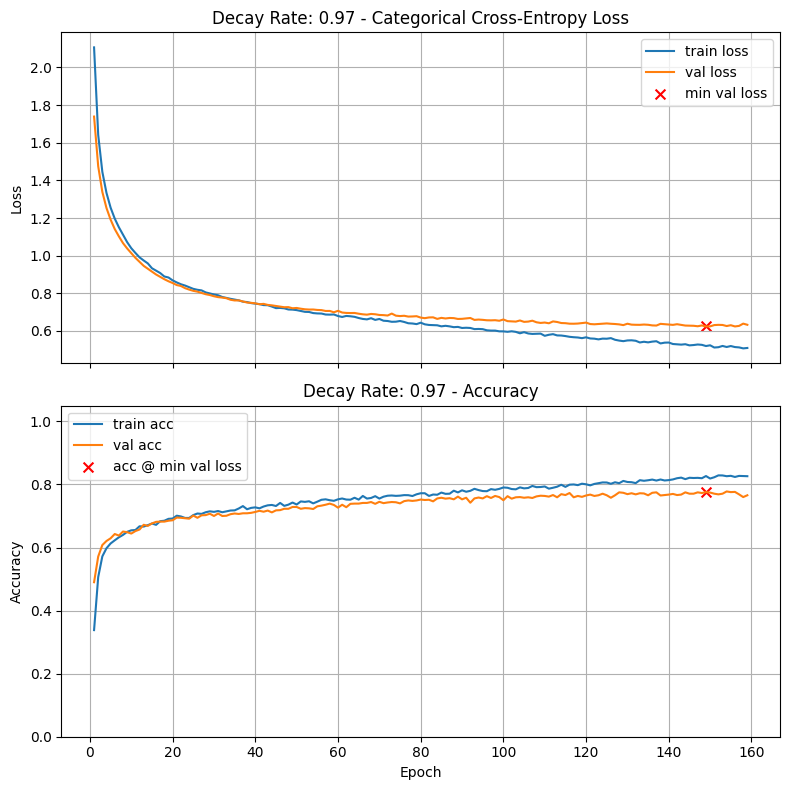

Final Training Loss:            0.5097
Final Training Accuracy:        0.8262
Final Validation Loss:          0.6329
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6239 (Epoch 149)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6468
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:20

Decay Rate: 0.98



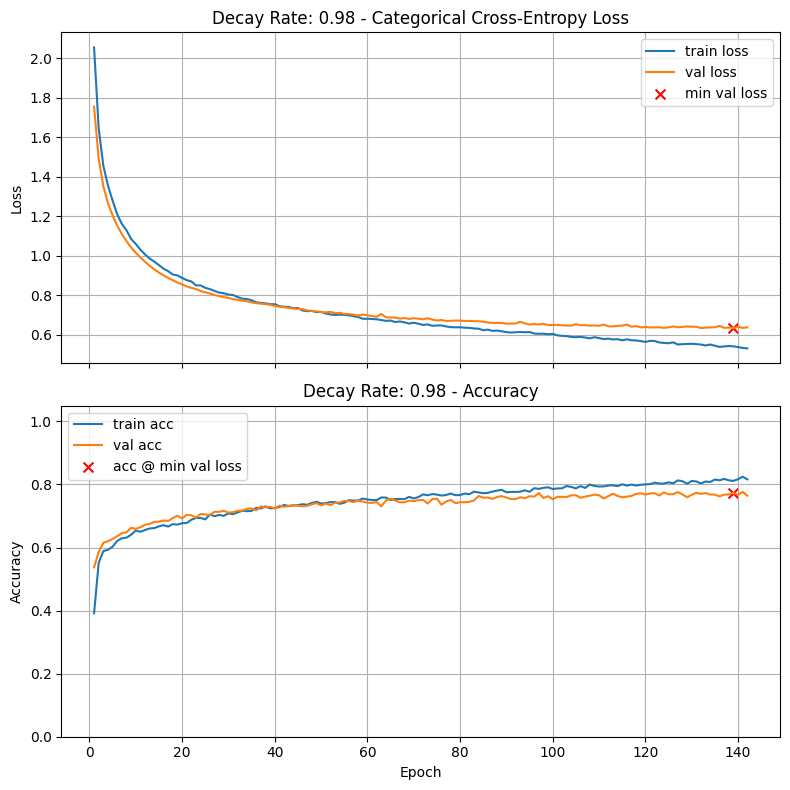

Final Training Loss:            0.5309
Final Training Accuracy:        0.8162
Final Validation Loss:          0.6376
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.6336 (Epoch 139)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.6613
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:19

Decay Rate: 0.99



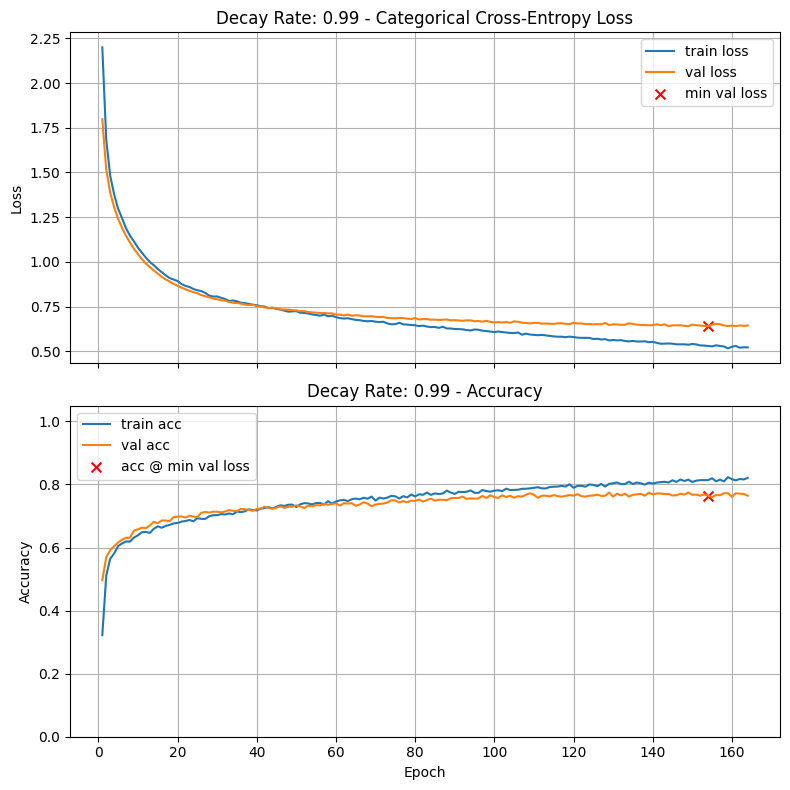

Final Training Loss:            0.5230
Final Training Accuracy:        0.8207
Final Validation Loss:          0.6452
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.6407 (Epoch 154)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6679
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:22


In [37]:
# Your code here. Add as many cells as you need.
lr_6 = 5e-4
af_6 = 'tanh'

reg_64_6 = 1e-4
reg_32_6 = 1e-2

drop_out_1st_layer_6 = 0.0
drop_out_2nd_layer_6 = 0.2

batch_size_6 = 6

decay_rates = np.linspace(.90, .99, 10)

results_6 = pd.DataFrame(columns=['First Layer Reg', 'Second Layer Reg', 'First Dropout', 'Second Dropout', 'Learning Rate', 'Batch Size', 'Decay Rate', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8,9])

for i, rate in enumerate(decay_rates):

    # Cosine Decay schedule (per-step)
    steps_per_epoch_6 = int(np.ceil(len(X_train) / batch_size_6))
    total_steps_6 = 500 * steps_per_epoch_6

    exp_decay = ExponentialDecay(
        initial_learning_rate=lr_6,
        decay_steps=total_steps_6,
        decay_rate=rate
        )

    model = build_model(X_train.shape[1], [ (64, af_6, reg_64_6, drop_out_1st_layer_6), (32, af_6, reg_32_6, drop_out_2nd_layer_6)], n_classes)
    history, metrics = train_and_test(model, lr_schedule=exp_decay, title=f"Decay Rate: {rate}", verbose=0, return_history = True)
    results_6.iloc[i] = [reg_64_6, reg_32_6, drop_out_1st_layer_6, drop_out_2nd_layer_6, lr_6, batch_size_6, rate, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]


In [38]:
results_6

,First Layer Reg,Second Layer Reg,First Dropout,Second Dropout,Learning Rate,Batch Size,Decay Rate,Best Val Accuracy,Min Val Loss
0,0.0001,0.01,0.0,0.2,0.0005,6,0.9,0.76,0.649042
1,0.0001,0.01,0.0,0.2,0.0005,6,0.91,0.768571,0.627063
2,0.0001,0.01,0.0,0.2,0.0005,6,0.92,0.779286,0.61753
3,0.0001,0.01,0.0,0.2,0.0005,6,0.93,0.769286,0.626292
4,0.0001,0.01,0.0,0.2,0.0005,6,0.94,0.775714,0.619734
5,0.0001,0.01,0.0,0.2,0.0005,6,0.95,0.785,0.625847
6,0.0001,0.01,0.0,0.2,0.0005,6,0.96,0.777143,0.642393
7,0.0001,0.01,0.0,0.2,0.0005,6,0.97,0.775714,0.623905
8,0.0001,0.01,0.0,0.2,0.0005,6,0.98,0.772857,0.633643
9,0.0001,0.01,0.0,0.2,0.0005,6,0.99,0.764286,0.640706


In [39]:
# Set a6 to the validation accuracy found by this best model

a6 = results_6['Best Val Accuracy'].max()           # Replace 0.0 with your answer

In [40]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7850


### Optional: Print out your results of all experiments

In [41]:
print_results()

Decay Rate: 0.95                        	0.7850
Learning Rate: 1e-05                    	0.7800
Decay Rate: 0.92                        	0.7793
Decay Rate: 0.96                        	0.7771
Learning Rate: 0.001                    	0.7764
Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3	0.7764
Decay Rate: 0.9400000000000001          	0.7757
Decay Rate: 0.97                        	0.7757
Learning Rate: 5e-05                    	0.7743
Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3	0.7729
Regularization: 0.0001, 0.001           	0.7729
Decay Rate: 0.98                        	0.7729
Learning Rate: 0.0005                   	0.7714
Regularization: 0.0001, 0.01            	0.7707
Learning Rate: 0.0001                   	0.7700
Decay Rate: 0.93                        	0.7693
Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4	0.7686
Decay Rate: 0.91                        	0.7686
Activation Function: tanh               	0.7679
Activation Function: sigmoid            	0.7679
Regularization: 0.001,

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?